# Preamble: install and import packages

In [1]:
%%capture
%pip install deepface mtcnn
##!pip install pandas==1.5 scikit-learn matplotlib deepface seaborn scikit-image tpot

In [112]:
import io # Input/Output Module
import os # OS interfaces
import numpy as np # linear algebra
import cv2 # OpenCV package
from matplotlib import pyplot as plt # Plotting library
plt.rcParams["figure.figsize"] = (8, 5)
import seaborn as sns # diffeerent plotting library
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle  # import pickle, to read and save variables
import time # measure elapsed time in execution
from typing import Callable # type hinting
from tqdm import tqdm # progress bar
# Scikit learn
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_predict
from sklearn.utils.fixes import loguniform
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, multilabel_confusion_matrix, matthews_corrcoef
from sklearn.decomposition import PCA
from skimage.exposure import rescale_intensity
from urllib import request # module for opening HTTP requests
# MTCNN, or Multi-Task Cascaded Convolutional Neural Networks
from mtcnn.mtcnn import MTCNN  
# DeepFace
from deepface import DeepFace
from deepface.detectors import FaceDetector
# PyTorch
import torch.optim
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
# Import VGG from Keras for final pipeline
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from keras.models import Model
from keras.layers import Dense, Flatten, Input
from keras.optimizers import Adam
import keras.callbacks

<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/internationaal/thinktank/fotos-en-logos/ku-leuven-logo.png/image_preview" width = 300px, heigh = auto align=left>
</div>


# KUL H02A5a Computer Vision: Group Assignment 1

Student numbers: <span style="color:red">r0708518, r0927391, r0925509, r0924356, r0912639</span>.

The goal of this assignment is to explore more advanced techniques for constructing features that better describe objects of interest and to perform face recognition using these features. This assignment will be delivered in groups of 5 (either composed by you or randomly assigned by your TA's).

In this assignment you are a group of computer vision experts that have been invited to ECCV 2021 to do a tutorial about  "Feature representations, then and now". To prepare the tutorial you are asked to participate in a kaggle competition and to release a notebook that can be easily studied by the tutorial participants. Your target audience is: (master) students who want to get a first hands-on introduction to the techniques that you apply.

---------------------------------------------------------------

# Feature representations: then and now

Welcome to the workshop on feature representations and their use in face recognition! This tutorial will take you from the basics of loading images to building handcrafted feature representations of faces and eventually introduces deep learning as a way to generate features.
This notebook is structured as follows:

0. Data loading & Preprocessing
1. Feature Representations
2. Evaluation Metrics 
3. Classifiers
4. Experiments
5. Publishing best results
6. Discussion

The most important contributions (improvements on the template notebook) are signified with an exclamation mark in the section title.

<!--

Make sure that your notebook is **self-contained** and **fully documented**. Walk us through all steps of your code. Treat your notebook as a tutorial for students who need to get a first hands-on introduction to the techniques that you apply. Provide strong arguments for the design choices that you made and what insights you got from your experiments. Make use of the *Group assignment* forum/discussion board on Toledo if you have any questions.

Fill in your student numbers above and get to it! Good luck! 


<div class="alert alert-block alert-info">
<b>NOTE:</b> This notebook is just a example/template, feel free to adjust in any way you please! Just keep things organised and document accordingly!
</div>

<div class="alert alert-block alert-info">
<b>NOTE:</b> Clearly indicate the improvements that you make!!! You can for instance use titles like: <i>3.1. Improvement: Non-linear SVM with RBF Kernel.<i>
</div>
-->

# 0. Data loading & Preprocessing

We will start the tutorial by reading the training and testing image data provided by the Kaggle competition. Next, we will preprocess the data in order to extract faces out of the images and distill features from them.

## 0.1. Loading data
You will notice that the training set is many times smaller than the test set. While this might strike you as odd, this is close to a real world scenario where your system might be put through daily use! In this session we will try to do the best we can with the data that we've got! *Note: this dataset is a subset of the* [*VGG face dataset*](https://www.robots.ox.ac.uk/~vgg/data/vgg_face/).

In [3]:
# Input data files are available in the read-only "../input/" directory
paths = ["/kaggle/input/kul-h02a5a-computer-vision-ga1-2023/"]

# TODO delete in Kaggle!!!
paths = ["D:\Coding\Datasets\CV_GA1_data"]

base_file_path = paths[0]

# Read train data with pandas csv
train = pd.read_csv(
    os.path.join(base_file_path, 'train_set.csv'), index_col = 0)
train.index = train.index.rename('id')

# Read test data with pandas csv
test = pd.read_csv(
    os.path.join(base_file_path, 'test_set.csv'), index_col = 0)
test.index = test.index.rename('id')

# Read the images as numpy arrays and store in "img" column
train['img'] = [cv2.cvtColor(np.load(os.path.join(base_file_path, 'train/train_{}.npy').format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in train.iterrows()]

## We processed the test image and will load it again afterwards
# test['img'] = [cv2.cvtColor(np.load(os.path.join(base_file_path, 'test/test_{}.npy').format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
#                 for index, row in test.iterrows()]

# Report sizes of train and test data
train_size, test_size = len(train), len(test)
"The training set contains {} examples, the test set contains {} examples.".format(train_size, test_size)

'The training set contains 80 examples, the test set contains 1816 examples.'

We define a global variable which allows us to enable or disable showing the plots, as plotting all images can slow down the notebook.

In [4]:
SHOW_PLOTS = False

## 0.2. A first look
Let's have a look at the data columns and class distributions. We can see that the training set contains an identifier, name of the person, the image as an array of pixel values, and the class label:

In [5]:
train.head(1)

,name,class,img
id,,,
0,Mila_Kunis,2,"[[[50, 31, 25], [49, 30, 24], [49, 30, 24], [4..."


The test set, on the other hand, does *not* have a class label: our goal will be to predict this using the information of the training data!

In [6]:
test.head(1)

,img
id,
0,-1


We can also look at the distributions of the different classes inside the training set:

In [8]:
train.groupby('name').agg({'img':'count', 'class': 'max'})

,img,class
name,,
Jesse_Eisenberg,30,1
Michael_Cera,10,0
Mila_Kunis,30,2
Sarah_Hyland,10,0


Note from the above table that **Jesse is assigned the classification label 1**, and **Mila is assigned the classification label 2**. The dataset also contains 20 images of **look alikes (assigned classification label 0)** and the raw images. 

## 0.3. Preprocess data


<!-- <div class="alert alert-block alert-info"> <b>NOTE:</b> You can write temporary files to <code>/kaggle/temp/</code> or <code>../../tmp</code>, but they won't be saved outside of the current session
</div> -->


Now that our data is loaded into the notebook, we will preprocess the images and detect faces present in the image.
First, we declare a variable that will set the final size of the faces for our pipeline. We chose for a size of (224, 244), which is the size used in the VGG-16 architecture that gives the best results in the final pipeline. Apart from that, we also define an auxiliary function to facilitate the plotting of a sequence of images.

In [9]:
FACE_SIZE = (224, 224)

In [10]:
def plot_image_sequence(data, imgs_per_row=10, cmap="Greys_r"):
    """Auxiliary function that plots a sequence of images in convenient format.
    Args:
        data (np.array): Sequence of images
        imgs_per_row (int, optional): Number of images on each row. Defaults to 7.
        cmap (str, optional): Colormap used in plotting. Defaults to "Greys_r" for greyscale images.
    """
    n = len(data)
    n_rows = n//imgs_per_row
    if n%imgs_per_row != 0:
        n_rows += 1
    n_cols = imgs_per_row
    fig, axs = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))
    for i in range(n):
        ax = axs[i//imgs_per_row, i%imgs_per_row]
        ax.imshow(data[i], cmap=cmap)
    # Disable ticks
    for row in axs:
        for ax in row:
            ax.set_xticks([])
            ax.set_yticks([])
    plt.show()


We also define an auxiliary function that, given an image and a face detected inside that image (specified by a bounding box around the face), allows us to modify the bounding box and e.g. enlarge it to include features such as hairstyle which are usually cropped from images by most face detectors.

In [11]:
def cut_out_face(img: np.array, x: int, y: int, width: int, height: int, width_factor: float = 0.1, height_factor: float = -1, 
                 center_x: int = None, center_y: int = None, square: bool = True) -> np.array:
    """
    Cuts out the face detected in an image with a modified bounding box.
    Args:
        img (np.array): Original image.
        x (int): The x coordinate of the bounding box of the detected face.
        y (int): The y coordinate of the bounding box of the detected face.
        width (int): The width of the bounding box of the detected face.
        height (int): The height of the bounding box of the detected face.
        width_factor (float, optional): Multiplier increasing the width of the bounding box. Defaults to 0.1.
        height_factor (float, optional): Multiplier increasing the height of the bounding box. Defaults to -1, such that it is set by the value of width_factor.
        center_x (int, optional): The x coordinate of a keypoint, such as nose or mouth. Defaults to None.
        center_y (int, optional): The y coordinate of a keypoint, such as nose or mouth. Defaults to None.
        square (boolean, optional): Specify whether bounding box has to be square-shaped. Defaults to True.
    Returns:
        np.array: Face cropped out of the original image.
    """
    
    # If height factor not set, default it to twice width factor
    if height_factor < 0:
        height_factor = 2 * width_factor
    
    # If we want the images to be square, adjust height or width (go for smallest square)
    if square:
        if width <= height:
            height = width
        else:
            width = height
            
    # In case a central point is provided, shift the coordinates to center that object
    if center_x is not None and center_y is not None:
        x = center_x - width/2
        y = center_y - height/2
    
    # Get the width and height of the image
    img_height, img_width = img.shape[0], img.shape[1]
    
    # Get new initial positions
    new_x = max(0, int(x - width_factor*width))
    new_y = max(0, int(y - height_factor*height))
    
    new_width  = min(img_width  - new_x, int((1 + 2*width_factor)*width))
    new_height = min(img_height - new_y, int((1 + 2*height_factor)*height))
    
    return img[new_y:new_y+new_height, new_x:new_x+new_width]

Since the face detectors fail to detect a face in an image occasionally (especially less refined techniques such as the HAAR detector), we will write an auxiliary function that gets the indices (inside a dataframe) of images that contain negative pixel values, which signals a failed detection.

In [12]:
def detect_negatives_images(imgs: np.array, verbose: bool = False) -> list:
    """
    Auxiliary function that saves the indices of images in a Numpy array that contain negative pixel values.
    Args:
        imgs (np.array): Sequence of images to be checked for negative pixel values.
        verbose (bool, optional): Signal whether to print the indices containing negative pixel values. Defaults to False.
    Returns:
        list: A list containing the indices containing negative pixel values.
    """
    # Save indices of images that have negative pixel values
    indices_to_delete = []
    for i, img in enumerate(imgs):
        if np.any(img.flatten() < 0):
            if verbose:
                print(f"Negative values in image {i} detected")
            indices_to_delete.append(i)
    return indices_to_delete

#### 0.3.1 Data augmentation/enhancement (!)

As already mentioned, the training data has just 80 examples, which is a quite low compared to the test set. In addition to that, some pictures have multiple people in them, are a montage of different pictures of the same person or are a meme mixing real people and cartoon figures. Therefore, in this section we will do a couple of things to improve and overall quality of the training data.

We will do a quick, manual crop of some images. Sometimes, that crop will result on an easier time for the face detection algorithms, since pictures that include 2 or more people will get simplified to just show the most important one (Sarah, Jesse, Michael or Mila). At the same time, some montages or memes can include different people we are interested in, that is why we will also perform some crops so that we can divide the pictures in 2 different ones with new labels that will increase the size of the data. In the table below, we summarize all augmentations/enhancement that we then perform in a cell below the table.

<style>
  :root {
    --col-width: 500px;
  }
  
  table {
    width: 100%;
    border-collapse: collapse;
  }
  
  th,
  td {
    padding: 8px;
    border: 1px solid black;
  }
  
  th:nth-child(1) {
    width: var(--col-width);
  }
  
  th:nth-child(2),
  th:nth-child(3) {
    width: calc((100% - var(--col-width)) / 2);
    max-width: var(--col-width);
  }
  .my-table th:nth-child(1) {
  width: var(--col-width);
}

.my-table th:nth-child(2),
.my-table th:nth-child(3) {
  width: calc((100% - var(--col-width)) / 2);
  max-width: var(--col-width);
}
</style>
<table class="my-table">
  <thead>
    <tr>
      <th>Index</th>
      <th>Before</th>
      <th>After</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>18</td>
      <td>Picture shows both Jesse and Michael, but is classified as Jesse (label = 1).</td>
      <td>Image at Index 18 just shows Jesse, and new image at Index 80 shows Michael with label = 0</td>
    </tr>
    <tr>
      <td>25</td>
      <td>The picture shows both Michael and a cartoon.</td>
      <td>Image cropped to just show Michael.</td>
    </tr>
      <tr>
      <td>28</td>
      <td>The picture shows Mila with 2 other people.</td>
      <td>Image cropped to just show Mila.</td>
    </tr>
      <tr>
      <td>29</td>
      <td>The picture shows Mila with another person.</td>
      <td>Image cropped to just show Mila.</td>
    </tr>
    <tr>
      <td>30</td>
      <td>The picture shows two pictures of Mila.</td>
      <td>Image separated to get two samples from it (Indexes 30 and 81).</td>
    </tr>
    <tr>
    <td>32</td>
      <td>The picture shows two pictures of Sarah.</td>
      <td>Image separated to get two samples from it (Indexes 32 &amp; 82).</td>
    </tr>
    <tr>
      <td>34</td>
      <td>The picture shows Michael, Jesse and a third person in a Pokémon meme.</td>
      <td>Image cropped to get Jesse at Index 34 and Michael at new Index 83.</td>
    </tr>
    <tr>
      <td>39</td>
      <td>The picture shows Mila with another person.</td>
      <td>Image cropped to just get Mila.</td>
    </tr>
    <tr>
      <td>40</td>
      <td>The picture shows Mila with another person.</td>
      <td>Image cropped to just get Mila.</td>
    </tr>
    <tr>
      <td>41</td>
      <td>The picture shows Michael with another person.</td>
      <td>Image cropped to just get him.</td>
    </tr>
    <tr>
      <td>49</td>
      <td>The picture shows Jesse with another person.</td>
      <td>Image cropped to just get him.</td>
    </tr>
    <tr>
      <td>50</td>
      <td>The picture shows Mila with another person.</td>
      <td>Image cropped to just get her.</td>
    </tr>
    <tr>
      <td>52</td>
      <td>The picture shows Jesse with another person.</td>
      <td>Image cropped to just get him.</td>
    </tr>
    <tr>
      <td>53</td>
      <td>The picture shows Jesse with another person.</td>
      <td>Image cropped to just get him.</td>
    </tr>
    <tr>
      <td>57</td>
      <td>The picture shows 2 photos of Mila.</td>
      <td>Image cropped to get one at Index 57 and the other at new Index 84.</td>
    </tr>
    <tr>
      <td>59</td>
      <td>The picture shows a photo of Sarah with another person.</td>
      <td>Image cropped to just get her</td>
    </tr>
    <tr>
      <td>61</td>
      <td>The picture shows a photo of Mila with another person.</td>
      <td>Image cropped to just get her</td>
    </tr>
    <tr>
      <td>70</td>
      <td>The picture shows a photo of Jesse with 2 other people.</td>
      <td>Image cropped to just get him.</td>
    </tr>
    <tr>
      <td>77</td>
      <td>The picture shows 2 photos of Mila.</td>
      <td>Image cropped to get one at Index 77 and the other at new Index 85.</td>
    </tr>
    <tr>
      <td>65</td>
      <td>The picture shows an "image not found" placeholder, due to possibly the data being corrupted.</td>
      <td>Image is deleted from improved training data.</td>
    </tr>
  </tbody>
</table>


In [14]:
# Copy the original training data, going to improve upon that below
train_improved = train.copy()
print("Length of TRAIN df: " + str(len(train_improved.index)))
# Index 18
aux = pd.DataFrame({"name": ["Michael_Cera"], "class": [0], "img": [train_improved.loc[18].img[:, 270:]]})
train_improved = train_improved.append(aux, ignore_index=True)
train_improved["img"][18] = train_improved.loc[18].img[:, :260]
# Index 25
train_improved["img"][25] = train_improved.loc[25].img[:, 200:]
# Index 28
train_improved["img"][28] = train_improved.loc[28].img[:, 275:625]
# Index 29
train_improved["img"][29] = train_improved.loc[29].img[:, :400]
# Index 30
aux = pd.DataFrame({"name": ["Mila_Kunis"], "class": [2], "img": [train_improved.loc[30].img[:, :100]]})
train_improved = train_improved.append(aux, ignore_index=True)
train_improved["img"][30] = train_improved.loc[30].img[:, 100:]
# Index 32
aux = pd.DataFrame({"name": ["Sarah_Hyland"], "class": [0], "img": [train_improved.loc[32].img[:, 420:]]})
train_improved = train_improved.append(aux, ignore_index=True)
train_improved["img"][32] = train_improved.loc[32].img[:, :420]
# Index 34
aux = pd.DataFrame({"name": ["Michael_Cera"], "class": [0], "img": [train_improved.loc[34].img[160:, :160]]})
train_improved = train_improved.append(aux, ignore_index=True)
train_improved["img"][34] = train_improved.loc[34].img[160:, 210:380]
# Index 39
train_improved["img"][39] = train_improved.loc[39].img[:, 125:220]
# Index 40
train_improved["img"][40] = train_improved.loc[40].img[:, 107:]
# Index 41
train_improved["img"][41] = train_improved.loc[41].img[:, :200]
# Index 49
train_improved["img"][49] = train_improved.loc[49].img[:, :150]
# Index 50
train_improved["img"][50] = train_improved.loc[50].img[:200, :]
# Index 52
train_improved["img"][52] = train_improved.loc[52].img[:, 325:]
# Index 53
train_improved["img"][53] = train_improved.loc[53].img[:, 300:]
# Index 57
aux = pd.DataFrame({"name": ["Mila_Kunis"], "class": [2], "img": [train_improved.loc[57].img[:, :100]]})
train_improved = train_improved.append(aux, ignore_index=True)
train_improved["img"][57] = train_improved.loc[57].img[:, 100:]
# Index 59
train_improved["img"][59] = train_improved.loc[59].img[:, 220:]
# index 61
train_improved["img"][61] = train_improved.loc[61].img[:, 200:]
# Index 70
train_improved["img"][70] = train_improved.loc[70].img[:, 175:]
# Index 77
aux = pd.DataFrame({"name": ["Mila_Kunis"], "class": [2], "img": [train_improved.loc[77].img[:, :100]]})
train_improved = train_improved.append(aux, ignore_index=True)
train_improved["img"][77] = train_improved.loc[77].img[:, 100:]
# Index 65
train_improved = train_improved.drop([65])
print("Length of improved TRAIN df: " + str(len(train_improved.index)))

Length of TRAIN df: 80
Length of improved TRAIN df: 85


### 0.3.2 HAAR preprocessor

Now that we cleaned up and augmented our training data, we are ready to extract faces out of the images. In this first example we use the [HAAR feature based cascade classifiers](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html) to detect faces. After detection, the faces are resized so that they all have the same shape. If there are multiple faces in an image, we only take the first one.

The first preprocessor we try out is the HaarPreprocessor. About this cascade classifiers it can be said that they are part of a machine learning approach where a lot of images with faces and others with any are needed to train the model. The extraction of the features of the images using white/black rectangles is quite inefficient, so Adaboost is used to select the best features, and for each feature, the best threshold is found. In the end, at the time of its implementation, a pretrained model is used from a XML file and the detection is mainly done with the method detectMultiScale.

In [15]:
class HAARPreprocessor():
    """Preprocessing pipeline built around HAAR feature based cascade classifiers. """
    
    def __init__(self, path, face_size):
        self.face_size = face_size
        file_path = os.path.join(path, "haarcascade_frontalface_default.xml")
        if not os.path.exists(file_path): 
            if not os.path.exists(path):
                os.mkdir(path)
            self.download_model(file_path)
        
        self.classifier = cv2.CascadeClassifier(file_path)
  
    def download_model(self, path):
        url = "https://raw.githubusercontent.com/opencv/opencv/master/data/"\
            "haarcascades/haarcascade_frontalface_default.xml"
        
        with request.urlopen(url) as r, open(path, 'wb') as f:
            f.write(r.read())
            
    def detect_faces(self, img):
        """Detect all faces in an image."""
        
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return self.classifier.detectMultiScale(
            img_gray,
            scaleFactor=1.2,
            minNeighbors=5,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE
        )
        
    def extract_faces(self, img):
        """Returns all faces (cropped) in an image."""
        
        faces = self.detect_faces(img)

        # original HAAR img size
        return [img[y:y+h, x:x+w] for (x, y, w, h) in faces]
        #return [cut_out_face(img, x, y, w, h) for (x, y, w, h) in faces]
    
    def preprocess(self, data_row):
        faces = self.extract_faces(data_row['img'])
        
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        
        # only return the first face
        return cv2.resize(faces[0], self.face_size, interpolation = cv2.INTER_AREA)
            
    def __call__(self, data):
        return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)

This HAAR preprocessor is now just used for the train data to show visualization examples in the following subsection and how the process of discarding bad images would look like, since better results can be achieved with other face detectors.

Either way, firstly the HAAR preprocessor object has to be created for its later use on the train data. (We save the preprocessed data and use a different face size for the sake of the tutorial on SIFT later on -- the final pipeline for the classifiers will not rely on the HAAR preprocessor)

In [16]:
haar_face_size = (100,100)
haar_preprocessor = HAARPreprocessor(path = '../../tmp', face_size=haar_face_size)
train_X_HAAR, train_y_HAAR = haar_preprocessor(train), train["class"].values

#### Visualization

Let us visualize the results of the HAAR preprocessor on the basic train data:

In [17]:
if SHOW_PLOTS:
    plot_image_sequence(train_X_HAAR, imgs_per_row=10)

As you can see, the HAAR detector occasionally fails to detect a face in an image. Hence, we will remove images that had any negative pixel value, since it would mean that there was no detection:

In [18]:
# Get the indices of the images with no detection
indices_to_delete = detect_negatives_images(train_X_HAAR, True)

# Update both the train_X and train_Y arrays deleting those unuseful examples
train_X_HAAR = np.delete(train_X_HAAR, indices_to_delete, axis=0)
train_y_HAAR = np.delete(train_y_HAAR, indices_to_delete, axis=0)
if SHOW_PLOTS:
    plot_image_sequence(train_X_HAAR, imgs_per_row=10)

Negative values in image 14 detected
Negative values in image 35 detected
Negative values in image 65 detected


We see that there are still some false detections, due to pieces of hair or a shirt. Hence, we manually remove these false positives and show how the final images would look like. Note that this means that the HAAR preprocessor is not robust or reliable, such that we will consider other face detectors below to process the test data.

In [19]:
# Try to remove images that aren't faces or aren't Mila, Jesse, Michael, or Sarah
indices_not_faces = [5, 17, 22, 23, 27, 33, 38, 47, 58, 59, 62, 67]
train_X_HAAR = np.delete(train_X_HAAR, indices_not_faces, axis=0)
train_y_HAAR = np.delete(train_y_HAAR, indices_not_faces, axis=0)
# Plot the images
if SHOW_PLOTS:
    plot_image_sequence(train_X_HAAR, imgs_per_row=10)

Finally, we could also look at the different people by their labels. For instance, we will show the images of Mila:

In [20]:
if SHOW_PLOTS:
    plot_image_sequence(train_X_HAAR[train_y_HAAR == 2], imgs_per_row=10)

### 0.3.3 MTCNN preprocessor

The HAAR preprocessing gives a limited performance when it comes to face detection. We hence cannot trust it to process the large test data and give reliable results. Therefore, other possibilities have been explored, and the first of them is a MTCNN preprocessor. MTCNN stands for **MultiTask Cascaded Convolutional Networks**, which is a deep learning approach that adopts a cascaded structure of 3 stages which exploits the correlation between face detection and alignment in unconstrained environments to move past the performance of other methods like the previous one.

In this section, we look at [this paper](https://arxiv.org/abs/1604.02878) and [this article](https://machinelearningmastery.com/how-to-perform-face-detection-with-classical-and-deep-learning-methods-in-python-with-keras/) for the implementation of the framework. The mtcnn package needs to be installed (which was done at the start of the notebook), and from that, the pipeline is built is a similar fashion to the other one.

In [21]:
class MTCNNPreprocessor():
    """Preprocessing pipeline built around MTCNN."""
    
    def __init__(self, face_size, width_factor = 0.2):

        self.face_size = face_size
        self.detector = MTCNN()
        self.width_factor = width_factor

    def detect_faces(self, img):
        """Detect all faces in an image."""
        
        # Make a copy, since MTCNN plots bounding boxes on top of our images
        return self.detector.detect_faces(img.copy())
        
    def extract_faces(self, img):
        """Returns all faces (cropped) in an image."""
        
        # Detect the faces
        faces = self.detect_faces(img)
        # Boxes contain x, y, w, h of bounding box of each detected face
        boxes    = [face['box'] for face in faces]  
        # Nose key gives x and y
        noses = [face['keypoints']['nose'] for face in faces]
        
        # Extract faces
        extracted_faces = []
        for i in range(len(faces)):
            x, y, w, h = boxes[i]
            center_x, center_y = noses[i]
            cut_out = cut_out_face(img, x, y, w, h, width_factor = self.width_factor, center_x = center_x, center_y = center_y)
            extracted_faces.append(cut_out)
        
        return extracted_faces
    
    def preprocess(self, data_row):
        faces = self.extract_faces(data_row['img'])
        
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        
        # only return the first face, and resize
        return cv2.resize(faces[0], self.face_size, interpolation = cv2.INTER_AREA)
            
    def __call__(self, data):
        return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)

In the same way as in the previous case, this MTCNN preprocessor is now just used for the train data to show visualization examples in the following subsection and how the process of discarding bad images would look like, since better results can still be achieved with the last preprocessing technique shown in this notebook. Also, by doing so, the differences between this first two approaches can be seen in the final pictures.

The first step, as always, is defining the instance of the MTCNN preprocessor object, to use right after on the train data. We use `%%capture` to suppress output of the MTCNN class within this notebook. Note that this preprocessor is slower than the HAAR preprocessor.

In [22]:
%%capture
mtcnn_preprocessor = MTCNNPreprocessor(FACE_SIZE)
train_X_MTCNN, train_y_MTCNN = mtcnn_preprocessor(train), train['class'].values

The output of MTCNN contains more than just a bounding box around a face, and an example output is shown below in comment. It is a dictionary which, besides the bounding box of the face under the key `box`, also contains a keyword `keypoints`. This is another dictionary containing keys of which the values indicate coordinates of important features of a face, such as locations of the eyes and nose. Our custom function `cut_out_face` allows users to give e.g. the coordinates of the nose, to center this keypoint location across all faces. Such centering is beneficial for instance for PCA, as we will discuss later on.

In [42]:
## Example output of detect_faces:
# {'box': [62, 102, 170, 220],
#   'confidence': 0.9995554089546204,
#   'keypoints': {'left_eye': (102, 194),
#    'right_eye': (187, 191),
#    'nose': (145, 243),
#    'mouth_left': (112, 273),
#    'mouth_right': (183, 269)}},

#### Visualization

We visualize the results of the MTCNN preprocessor on the basic train data:

In [23]:
if SHOW_PLOTS:
    plot_image_sequence(train_X_MTCNN, imgs_per_row=10)

And now, in the same way it was done in the HAAR case, the non-detections and some bad results are discarded to get a final cleaned set of images:

In [24]:
# Remove some manually detected bad results
indices_not_faces = [8, 28, 30, 40]
train_X_MTCNN = np.delete(train_X_MTCNN, indices_not_faces, axis=0)
train_y_MTCNN = np.delete(train_y_MTCNN, indices_not_faces, axis=0)

# Discard non-detections
indices_to_delete = detect_negatives_images(train_X_MTCNN, True)

# Update both the train_X and train_Y arrays deleting those indices
train_X_MTCNN = np.delete(train_X_MTCNN, indices_to_delete, axis=0)
train_y_MTCNN = np.delete(train_y_MTCNN, indices_to_delete, axis=0)
# Plot image sequence
if SHOW_PLOTS:
    plot_image_sequence(train_X_MTCNN,  imgs_per_row=10)

Negative values in image 61 detected


Below, we will not continue with the MTCNN preprocessor, we delete the variables to clean up memory

In [25]:
del train_X_MTCNN
del train_y_MTCNN

### 0.3.4 DeepFace preprocessor

The final face detector we explore is **DeepFace**. To explain how the DeepFace preprocessor works and provide a motivation for its use, let's look at an example. Both HAAR and MTCNN failed on training image with index 49, shown below. The detectors have a more confidence detection due to Kristen Stewart. We can exploit the knowledge from the class label, and use a template of Jesse to force our detector to detect Jesse's face instead by relying on a similarity score. Note that we can also prevent this issue by cropping the image such that only the person we wish to detect is in the image, as we did in the beginning of our preprocessing. However, it is clear that the method provided by DeepFace is more robust, and is easily scalable towards larger datasets. 

In [26]:
test_image = train.loc[49].img
if SHOW_PLOTS:
    plt.imshow(test_image)
    plt.show()

We saved a template where Jesse's face is clearly visible and the single face in the picture. We load it in:

TODO - get correct path to templates and also consider how to do this in Kaggle, the templates are just images from the training data so we can also just get those since it doesn't have to be a .png but can also be a simple numpy array, so perhaps it's better to find a nice image to be used as template, then load in the full (non-preprocessed) image and use those as templates, since then we don"t have to save them in Kaggle or anything.

In [27]:
template_jesse = cv2.imread("template_jesse.png")
# We have to convert to RGB
template_jesse = template_jesse[...,::-1]

We then use DeepFace's "verify" method, which compares two images and verifies that the same person is present in both images. In the example output, we see that DeepFace then gives us two facial areas: one for each image. Since we are not interested in the template, we take the face from the first image. Below, we show an example output in comment. 

In [28]:
result = DeepFace.verify(img1_path = test_image, img2_path = template_jesse)

In [29]:
### Example output:
# {'verified': True,
#  'distance': 0.11051846168495327,
#  'threshold': 0.4,
#  'model': 'VGG-Face',
#  'detector_backend': 'opencv',
#  'similarity_metric': 'cosine',
#  'facial_areas': {'img1': {'x': 65, 'y': 49, 'w': 54, 'h': 54},
#   'img2': {'x': 116, 'y': 83, 'w': 124, 'h': 124}},
#  'time': 2.23
# }

The detected face, when cropped out and plotted  below, is indeed Jesse's face -- we hence were able to detect the desired face in this image due to DeepFace!

In [30]:
face = result["facial_areas"]["img1"]
x, y, w, h = face["x"], face["y"], face["w"], face["h"]
# Plot the face
if SHOW_PLOTS:
    plt.imshow(test_image[y:y+h, x:x+w])
    plt.show()

In case we cannot use the template (it is not Jesse or Mila), we have to resort back to a simple face detector to detect faces. There are several detectors implemented in DeepFace, which can be accessed by providing the right name as a string. For instance, the `opencv` detector is simply the HAAR cascade detector we discussed earlier. Also, the MTCNN detector is implemented here. A more state-of-the-art detector based on deep learning is also implemented and selected in the end, known as [RetinaFace](https://arxiv.org/pdf/1905.00641.pdf).

RetinaFace achieves better results compared to both HAAR and MTCNN since it combines face detection, landmark localization and face bounding box regression. Its network is composed of a feature extraction part and convolutional layers that predict the boxes, confidence scores and landmark points. These last ones are also what it is used to align the faces to desired poses. It has been chosen because it achieves higher accuracy and robustness in changing conditions and poses while being only slightly slower in comparison to HAAR and MTCNN.

In [31]:
detector_name = "retinaface"
detector = FaceDetector.build_model(detector_name) #options: opencv, ssd, dlib, mtcnn or retinaface
obj = FaceDetector.detect_faces(detector, detector_name, test_image)

The output is a list containing the original image, the bounding box of the face, and some score of the detection. Unfortunately, RetinaFace does not give locations of keypoints as MTCNN did. Getting the face out of the image is done as follows:

In [32]:
x, y, w, h = obj[0][1]
# Plot the face
if SHOW_PLOTS:
    plt.imshow(test_image[y:y+h, x:x+w])
    plt.show()

`DEEPPreprocessor` is a preprocessor based on [DeepFace](https://github.com/serengil/deepface). 

In [33]:
class DEEPPreprocessor():
    
    def __init__(self, face_size, template_jesse_loc ="template_jesse.png", template_mila_loc = "template_mila.png",
                 detector_name = "retinaface", width_factor = 0.1):
        """Preprocessing pipeline built around DeepFace. 

        Args:
            face_size (tuple[int, int]): Size of the faces for resizing after successful face detection.
            template_jesse_loc (str, optional): Filename of template image of Jesse. Defaults to "template_jesse.png".
            template_mila_loc (str, optional): Filename of template image of Mila. Defaults to "template_mila.png".
            detector_name (str, optional): Argument required by DeepFace's FaceDetector object. Possible choices are
            opencv, ssd, dlib, mtcnn or retinaface. Defaults to "retinaface".
            width_factor (float, optional): When cutting out the face in an image, specify the width of the bounding box. Defaults to 0.
        """
        
        # Save face size and width factor for bounding boxes
        self.width_factor = width_factor
        self.face_size = face_size
        
        # Load in Jesse's template
        self.template_jesse = cv2.imread(template_jesse_loc)
        self.template_jesse = self.template_jesse[...,::-1]
        
        # Load in Mila's template
        self.template_mila = cv2.imread(template_mila_loc)
        self.template_mila = self.template_mila[...,::-1]
        
        # Initialize face detector
        self.detector_name = detector_name
        self.detector = FaceDetector.build_model(self.detector_name) 
        
            
    def extract_face(self, img, label):
        """Detect and cut out face out of the image. NOTE - unlike HAAR and MTCNN, DeepFace methods detects a single face.
        This method decides how to detect faces based on the label that is provided, and hence can only be used on training data
        to improve the face detection and extraction. If the label is 1 or 2, we rely on the templates of Jesse and Mila to 
        improve the performance of the detector (cf. Kristen Stewart example).

        Args:
            img (np.array): Image.
            label (int): Class label of training data.

        Returns:
            np.array: Face cropped out of the image.
        """
        
        # Initialize the face bounding box to an empty box (in case no detection, still empty box)
        x, y, w, h = 0, 0, 0, 0
        # In case we do NOT have Jesse or Mila, just use face detector
        if label == 0:
            # Detect a face
            face = FaceDetector.detect_faces(detector, self.detector_name, img)
            # Get the bounding box
            if face is not None and len(face) > 0:
                x, y, w, h = face[0][1]
        else:
            # In case we know we have to detect Jesse or Mila, make sure we detect them! Use "verify"
            if label == 1:
                template = self.template_jesse
            elif label == 2:
                template = self.template_mila
            # Use template to verify faces
            result = DeepFace.verify(img1_path = img, img2_path = template, enforce_detection=False)
            face = result["facial_areas"]["img1"]
            x, y, w, h = face["x"], face["y"], face["w"], face["h"]
            
        return cut_out_face(img, x, y, w, h, width_factor=self.width_factor)
    
    def preprocess(self, data_row):
        """Preprocesses the data and extracts the images out of it.

        Args:
            data_row (pd.DataFrame): Pandas dataframe of training data (images and class labels).

        Returns:
            _type_: _description_
        """
        
        # Detect face
        face = self.extract_face(data_row['img'], data_row['class'])
        
        # No face detected, return nan image                
        if len(face.flatten()) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        
        # Resize if face detected
        return cv2.resize(face, self.face_size, interpolation = cv2.INTER_AREA)
            
    def __call__(self, data):
        return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)

We now use the DeepFace preprocessor on the training data. Note that this preprocessor is computationally the heaviest of all three discussed!

In [34]:
deep_preprocessor = DEEPPreprocessor(FACE_SIZE)
train_X_DEEP, train_y_DEEP = deep_preprocessor(train), train['class'].values
# Plot
img_seq = train_X_DEEP
if SHOW_PLOTS:
    plot_image_sequence(img_seq, imgs_per_row=10)

Again, we delete a few bad faces:

In [35]:
indices_not_faces = [40, 65]
train_X_DEEP = np.delete(train_X_DEEP, indices_not_faces, axis=0)
train_y_DEEP = np.delete(train_y_DEEP, indices_not_faces, axis=0)
# Plot
if SHOW_PLOTS:
    plot_image_sequence(train_X_DEEP, imgs_per_row=10)

Since we are going to use the augmented data, we again delete the above data for the sake of memory/performance:

In [38]:
del train_X_DEEP
del train_y_DEEP

### 0.3.5 Selection of data to work with

After the demonstrations above, where we showcased three face detectors and discussed their (dis)advantages, we will now choose to work with DeepFace, as RetinaFace is likely the most effective model out of the three detectors we have discussed. Hence, we hope to maximize the number of (true) detections on the test set with RetinaFace. Since the classifiers will extract features from this preprocessed data, it makes sense to use the same detection strategy for the training set. Hence, below we process the entire augmented training dataset with RetinaFace.

In [36]:
deep_preprocessor = DEEPPreprocessor(FACE_SIZE)
train_X_DEEP, train_y_DEEP = deep_preprocessor(train_improved), train_improved['class'].values
# Plot
if SHOW_PLOTS:
    plot_image_sequence(train_X, imgs_per_row=10)

In the remainder of the tutorial, we will work with this preprocessed training data, so we save it in an additional variable:

In [37]:
train_X = train_X_DEEP
train_y = train_y_DEEP

## 0.4. Store Preprocessed data (optional)
<div class="alert alert-block alert-info">
<b>NOTE:</b> You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All". Feel free to use this to store intermediary results.
</div>

In [39]:
# save preprocessed data
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     os.mkdir(prep_path)
    
# np.save(os.path.join(prep_path, 'train_X.npy'), train_X)
# np.save(os.path.join(prep_path, 'train_y.npy'), train_y)
# np.save(os.path.join(prep_path, 'test_X.npy'), test_X)

# load preprocessed data
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     os.mkdir(prep_path)
# train_X = np.load(os.path.join(prep_path, 'train_X.npy'))
# train_y = np.load(os.path.join(prep_path, 'train_y.npy'))
# test_X = np.load(os.path.join(prep_path, 'test_X.npy'))

*Note*: We have used the DeepFace preprocessor on the test set as well. However, this is computationally very intensive (processing the whole dataset took us around 3 hours of computing), which is why we do not re-do the preproccesing here. Rather, we will import the data and point towards the relevant directory. 

TODO - provide correct path for the preprocessed test data such that it works in Kaggle

In [41]:
test_prep_X_loc = os.path.join(base_file_path, "test_preprocessed")
print(f"Loading preprocessed test data from {test_prep_X_loc}")

Loading preprocessed test data from D:\Coding\Datasets\CV_GA1_data\test_preprocessed


# 1. Feature Representations

Now that we preprocessed the data and extracted the faces out of the provided training data with an effective face detector, the next step is to build lower-dimensional representations, known as **feature representations** of the faces of each of the three classes. These features will be provided to our classifiers later on to be able to infer the class (recognize the face) in a new image.

Our feature extractors will be subclasses of a simple base class that implements the identity function:
$$
\forall x : f(x) = x.
$$


In [42]:
class IdentityFeatureExtractor:
    """A simple function that returns the input"""
    
    def transform(self, X):
        return X
    
    def __call__(self, X):
        return self.transform(X)

## 1.1. Baseline 1: Scale Invariant Feature Transform (SIFT)

The first method to extract features out of images is the **scale invariant feature transform** (SIFT). SIFT is a method of feature extraction that is invariant to various transformations, such as scale, orientation, angle, etc. This makes it a promising method for face recognition as it can extract facial features specific to a person of interest from various images. A successful SIFT implementation is robust (same features are extracted from the same object in different conditions) and discriminative (different image objects can be easily separated from each other in feature space).

In this section we will implement SIFT using the opencv framework and demonstrate the advantages and disadvantages of these handcrafted features.

In [43]:
class SIFTFeatureExtractor(IdentityFeatureExtractor):

    # initialize feature extractor
    def __init__(self, nFeatures, sigma, nOctaveLayers = 3, contrastThreshold = .04, edgeThreshold=10):
        self.nFeatures = nFeatures
        self.sigma = sigma
        self.allDescriptors = None
        self.allKeypoints = None
        self.sift = cv2.SIFT_create(nfeatures=nFeatures, sigma=sigma, nOctaveLayers=nOctaveLayers, contrastThreshold=contrastThreshold, edgeThreshold=edgeThreshold)

    # get keypoints and feature descriptors for each image
    def detect_and_compute(self, images):
        all_descriptors = np.zeros((len(images),self.nFeatures, 128))
        all_keypoints = []
        # iterate over all images
        for i in range(len(images)):
            im = np.array(images[i], dtype='uint8')
            # convert to grayscale
            gray= cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
            # apply bilateral filter to reduce noise
            filtered = cv2.bilateralFilter(gray, 3,150,150)
            # detectAndCompute returns keypoints and feature descriptors
            kp1, des1 = self.sift.detectAndCompute(filtered, None)
            (rows,columns) = des1.shape
            # maintain only nFeatures features for each image
            if rows>self.nFeatures:
                des1 = des1[0:self.nFeatures]
            all_descriptors[i] =np.array(des1)
            all_keypoints.append(np.array(kp1)[0:self.nFeatures])
        self.allKeypoints = all_keypoints
        self.allDescriptors = all_descriptors
        return all_descriptors, all_keypoints

    # return all matching features between two images
    def match(self, des1, des2):
        FLANN_INDEX_KDTREE = 0
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks=50) # or pass empty dictionary
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        matches = matcher.knnMatch(np.float32(des1), np.float32(des2), k=2)
        return matches

    # draw the keypoints of an image
    def drawKeypoints(self, img, keypoints):
        image = np.zeros((100,100,3))
        image =cv2.drawKeypoints(img,keypoints,image)
        plt.imshow(image)

    # draw the matches between two images
    def drawMatches(self, im1, kp1, des1, im2, kp2, des2):
        matches = self.match(des1, des2)
        ratio_thresh = .85
        good_matches = []
        for m,n in matches:
            if m.distance < ratio_thresh * n.distance:
                good_matches.append([m])
        im = cv2.drawMatchesKnn(im1, kp1, im2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        fig=plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111)
        ax.imshow(im)
        plt.show()

    # filter out the poor matches between two images
    def getGoodFeatures(self, class_template, desc, kp):
        good_descriptors = []
        good_keypoints = []
        for i,des in enumerate(desc):
            matches = SIFTExtractor.match(class_template, des)
            # measure euclidian distance between two matches
            ratio_thresh = .85
            for m,n in matches:
                if m.distance < ratio_thresh * n.distance:
                    good_descriptors.append(des[m.queryIdx])
                    good_keypoints.append(kp[i][m.queryIdx])
        return good_descriptors, good_keypoints

### 1.1.1. Extracting Features

Here, we will demonstrate how to use SIFT and interpret the results. First we initialize our SIFT extractor with the parameters `nFeatures=10` and `sigma=.9`. Selecting a value of 10 for `nFeatures` allows our SIFT extractor to limit keypoints to discriminative features such as the contours of the eyes, nose, mouth. The `sigma` parameter represents the sigma of the Gaussian that is applied to the image. Since our images have a weak quality and an additional bilateral filter is applied to each image before extracting features, we reduce this number.

These values (as well as the optional parameters `contrastTreshold`, `edgeThreshold`, `nOctaveLayers`) can be customized for various recognition tasks and depending on the quality of the input images.

In [44]:
SIFTExtractor = SIFTFeatureExtractor(nFeatures=10, sigma=.6, nOctaveLayers = 3, contrastThreshold = .04, edgeThreshold=10)

As an example, the descriptors and keypoints are extracted from four images. The matches between these four images will be visualized in the following cells. (For the discussion on SIFT, we rely on the HAAR preprocessed data)

In [45]:
# get keypoint and feature descriptors from each class of data
descriptors_mila, keypoints_mila = SIFTExtractor.detect_and_compute(train_X_HAAR[train_y_HAAR==2])
descriptors_jesse, keypoints_jesse = SIFTExtractor.detect_and_compute(train_X_HAAR[train_y_HAAR==1])
descriptors_michael_and_sarah, keypoints_michael_and_sarah = SIFTExtractor.detect_and_compute(train_X_HAAR[train_y_HAAR==0])

gray_jesse_1      = cv2.cvtColor(np.uint8(train_X_HAAR[train_y_HAAR==1][0]),cv2.COLOR_BGR2GRAY)
gray_jesse_2      = cv2.cvtColor(np.uint8(train_X_HAAR[train_y_HAAR==1][1]),cv2.COLOR_BGR2GRAY)
gray_michael_1 = cv2.cvtColor(np.uint8(train_X_HAAR[train_y_HAAR==0][0]),cv2.COLOR_BGR2GRAY)
gray_mila_1        = cv2.cvtColor(np.uint8(train_X_HAAR[train_y_HAAR==2][0]),cv2.COLOR_BGR2GRAY)

Here we visualize the keypoints on an image of Jesse Eisenberg. Notably, we can see some distinct features extracted from the eyes, mouth, and nostrils. Additional extracted features we can expect from other images in our datasest include the hair and ears.

One unexpected feature comes from the background of the current image. This could be removed my improving the cropping in the preprocessing of the dataset.

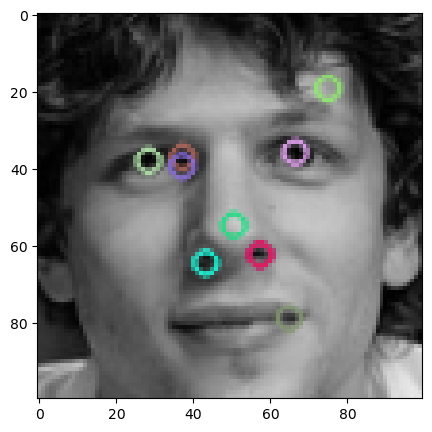

In [46]:
SIFTExtractor.drawKeypoints(gray_jesse_1, keypoints_jesse[0])

Let's visualize the features of two different images of Jesse Eisenberg. We see that the eye and nostril feature descriptors are identified as matching by the SIFT extractor in both image representations. We do however see that the extractor matches one feature incorrectly. This may be evidence of the feature extractor being too local. Nonetheless, the features are identified as specific to Jesse Eisenberg.

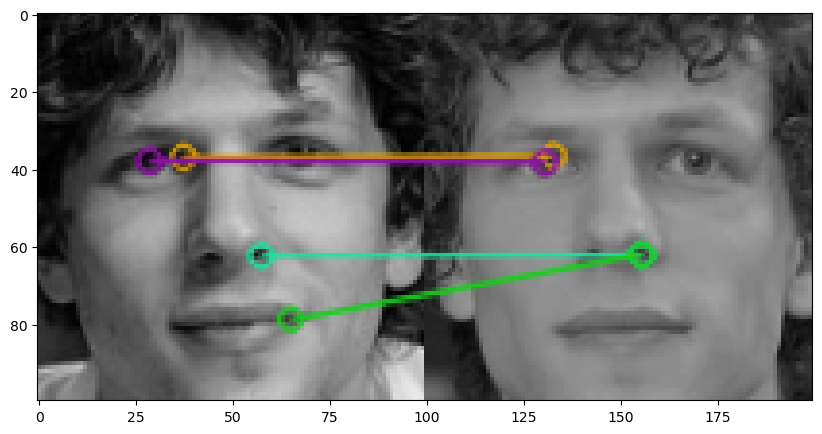

In [47]:
SIFTExtractor.drawMatches(gray_jesse_1, keypoints_jesse[0], descriptors_jesse[0], gray_jesse_2, keypoints_jesse[1], descriptors_jesse[1])

Now we visualize the features of Jesse Eisenberg and Mila Kunis. We see that no features are identified as matching between these two images. This suggests that the feature representations are discriminative as they are distinguishable between two different people.

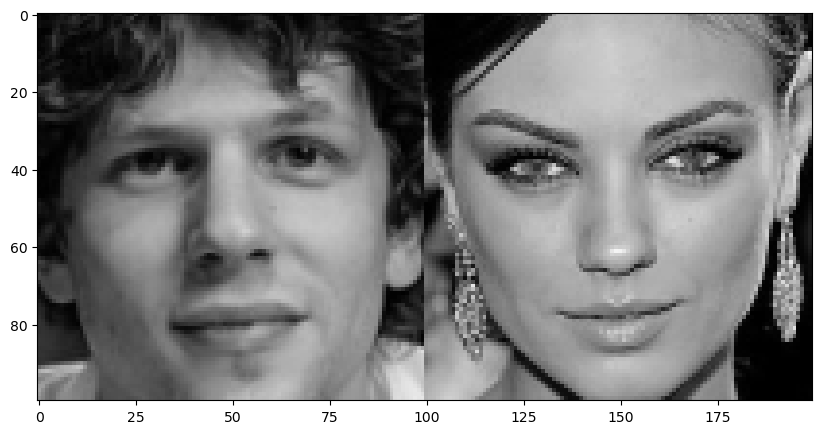

In [48]:
SIFTExtractor.drawMatches(gray_jesse_1, keypoints_jesse[0], descriptors_jesse[0], gray_mila_1, keypoints_mila[0], descriptors_mila[0])

A true test of our feature recognition system is comparing the features of two 'lookalikes'. For this we visualize the features of Jesse Eisenberg and Michael Cera. The SIFT extractor matches a feature on Jesse and Michael's eye which shows that the matcher is not as discriminative with lookalikes.

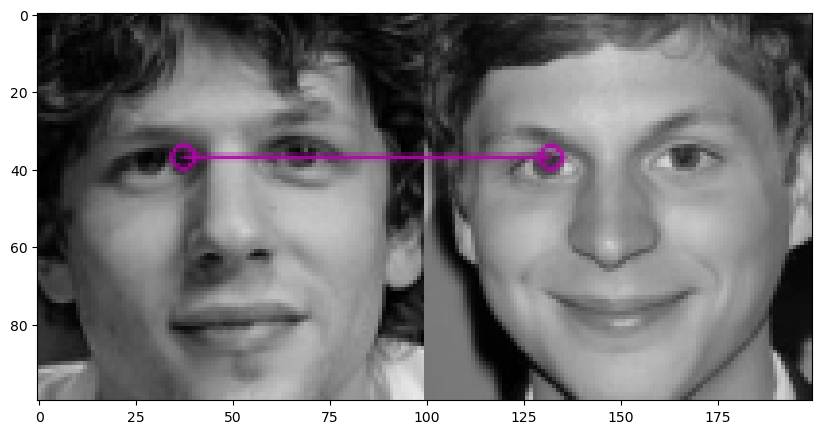

In [49]:
SIFTExtractor.drawMatches(gray_jesse_1, keypoints_jesse[0], descriptors_jesse[0], gray_michael_1, keypoints_michael_and_sarah[0], descriptors_michael_and_sarah[0])

### 1.1.2. T-SNE Plot

The features we extracted with SIFT are still located in a high-dimensional space, such that it is hard to visualize the feature representations of our training images. In order to visualize them, we have to postprocess the features with a **T-SNE** or **t-Distributed Stochastic Neighbor Embedding**, which is a method used to visualie high dimensional data in fewer dimensions.

Here we visualize the good descriptors of Jesse Eisenberg and Mila Kunis. A descriptor is deemed good if it is similar to other descriptors in the same locality of the image. Similarity here is measured with euclidean distance.

In this section we will use the t-SNE framework from sklearn. We first initialize a TSNE object with the parameters `n_components=2`, `perplexity=20`, `early_exaggeration=20` and the optional parameters `learning_rate='auto'`, `init='random'` and  `n_iter=2000`.

We choose 2 for the number of components because it more intuitive for visualization purposes. Perplexity is generally a value between 5 and 50 that represents the balance between local and global features in our feature space. We choose 50 for this value as we estimate 50 near neighbors in each class. A value of 20 is chosen for `early_exaggeration` to accentuate the distance between classes.

T-SNE uses a factor of randomization to create the plot, thus each run may result in a slightly different distribution. Nonetheless we can see that the features for Jesse and Mila form two distinct classes. However, in some runs the distance between these two classes is not very big. This is expected as the feature representations for facial features may be similar even from person to person.

[t-SNE] Computing 56 nearest neighbors...
[t-SNE] Indexed 57 samples in 0.000s...
[t-SNE] Computed neighbors for 57 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 57 / 57
[t-SNE] Mean sigma: 373.360946
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.220764
[t-SNE] KL divergence after 1000 iterations: 0.053460
[t-SNE] Computing 58 nearest neighbors...
[t-SNE] Indexed 59 samples in 0.001s...
[t-SNE] Computed neighbors for 59 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 59 / 59
[t-SNE] Mean sigma: 347.731283
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.970581
[t-SNE] KL divergence after 700 iterations: 0.066492


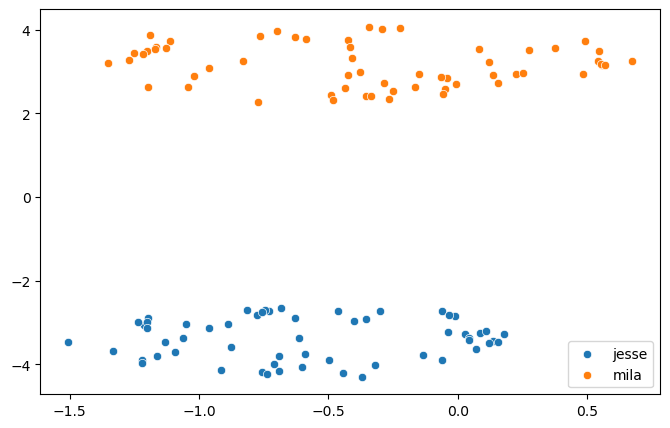

In [50]:
# Get the 'good' descriptors of all images of mila and jesse. A descriptor is deemed good if it is similar to other descriptors in the same locality of the image where similarity is measured with euclidean distance.
good_mila_descriptors, _ = SIFTExtractor.getGoodFeatures(descriptors_mila[0], descriptors_mila, keypoints_mila)
good_jesse_descriptors, _ = SIFTExtractor.getGoodFeatures(descriptors_jesse[0], descriptors_jesse, keypoints_jesse)

# plot the tsne
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=50, n_iter=2000, verbose=1, early_exaggeration=20)
z_jesse = tsne.fit_transform(np.array(good_jesse_descriptors))
z_mila = tsne.fit_transform(np.array(good_mila_descriptors))

sns.scatterplot(x=z_jesse[:,0], y=z_jesse[:,1], label='jesse')
sns.scatterplot(x=z_mila[:,0], y=z_mila[:,1], label='mila')
plt.show()

### 1.1.3. Discussion
In this section we observed that the handcrafted SIFT features are discriminative. From both the visualized matching keypoints and the TSNE plot we observe that SIFT effectively separates features of two different people, namely Jesse Eisenberg and Mila Kunis.

In regard to robustness, the handcrafted features perform less effectively in this domain. While the SIFT extractor generally extracts a few features effectively (such as the eye and nostril features in the first image of Jesse Eisenberg), only a few 'good' features are extracted for each image. A more robust system would extract features from the eyes, nose, mouth, and ears for each image regardless of the image conditions. The system can be made more robust by improving the preprocessing of images before extracting features. While the SIFT extractor applies a guassian to images before grabbing features, additional steps such as normalizing contrast and brightness could improve the definition of features.

Compared to the previous grabbing task in the individual assignment, the SIFT extractor applied in facial recognition must be more local. What is meant by this is that distinguishing features from person to person is a more difficult task than object recognition seen in the previous assignment. Because of this the SIFT extractor needs to be well tuned to distinguish slight the intricacies of facial features.

## 1.2. Baseline 2: PCA feature extractor

The second method to extract features out of image data that we explore is principal component analysis. __Principal Component Analysis__ (PCA) is a technique used to extract highly variant components (set of points) from data. In our case, we will apply it to faces in order to extract those components that make up the variability of the faces. Ideally, we would discretize or isolate components containing facial features that can be later used to discriminate the faces in our dataset. Most of the work in applying this method relies in picking informative components and the least amount of background noise as well as aligning the faces to a reference point to reduce variance generated only based on the location of the face.

For PCA, we first convert each image in our training set into a one-dimensional array by flattening the images. If color images are used, we flatten each color channel and concatenate them. For simplicity, we discuss the case of performing PCA on square grasycale images, each having the same size $K\times K$ (with, by default, $224\times 224$ for our training set). After flattening, we hence have a matrix $M$, often called the __data matrix__ of size $Z \times K^2$, with $Z$ the number of training examples. The columns (flattened pixels) then represent random variables, while the rows indicate different samples of those random variables. In our case, the matrix hence has size $80 \times 10 \ 000$. Given this data matrix, we zero-mean the dataset. That is, we compute the mean of each column and subtract it from all training examples. The reason behind centering the data is that the covariance matrix is sensitive to the mean of the data: without centering, the covariance matrix will reflect the location of the mean of the data (the bias in the training data) as well as its variability, which makes for a worse PCA performance.

There are then two ways to proceed with PCA. The first option is to compute the covariance matrix of this data matrix $M$. This will give a covariance matrix $C$ of size $K^2 \times K^2$, of which we compute the eigenvalue decomposition (EVD). The principal components are then determined by the largest eigenvalues and their corresponding eigenvectors of this covariance matrix, since they indicate the directions of highest variance. By keeping $q$ principal components, we compute a projection matrix of size $q \times K^2$ which stores the corresponding eigenvectors as columns. Given a flattened image $x$ with shape $K^2 \times 1$, we can compute a lower-dimensional representation $z = W\cdot x$, and $z$ is often referred to as the __feature vector__. The time complexity of computing the EVD on a $n\times n$ matrix is $\mathcal{O}(n^3)$.

The other approach is to use **singular value decomposition** (SVD). It generalizes the concept of eigenvalue decomposition, which can only be applied to square matrices, to matrices of any shape. Similar to the EVD case, here we keep the $q$ largest singular values and their corresponding vectors as the principal components. The time complexity of computing the SVD on a $m\times n$ matrix is $\mathcal{O}\left( \text{min}\left( mn^2, m^2 n \right) \right)$.

In our case, the matrix of interest has shape $80 \times 10 \ 000$. Due to this dimensionality, computing the SVD of this matrix is much more efficient than the EVD. During our experiments, we noted that computing the EVD on the covariance matrix could easily take more than 10 minutes, whereas the SVD takes only a few seconds. We did not see any significant advantage for the EVD in terms of performance. As such, we decided to stick to the SVD in this implementation. Our implementation makes use of scikit-learn's PCA, which in turn calls numpy's SVD optimised function.

One challenge with PCA is choosing the number of principal components. One way to choose this value is by looking at the eigenvalues/singular values $\lambda_i$, $i = 1, ..., N$ of the data matrix, ordered in decreasing magnitude. (For EVD, $N$ equals $K^2$, while for SVD, $N$ equals $Z$). We can then decide the number of principal components $q$ by requiring that these components explain a certain percentage $p$ of the variance in the dataset, *i.e.* choose $q$ such that
\begin{equation*}  
    \frac{\sum_{i=1}^q \lambda_i}{\sum_{i=1}^N \lambda_i} \geq p \, .
\end{equation*}  
Another approach could be to investigate the average reconstruction loss on the training images. In the end, the number of principal components is another hyperparameter of the classifier, and one needs to carefully tune this hyperparameter, such as via a knee plot. 

Lastly, although already mentioned briefly, it is worth explaining the decision behind doing the mean subtraction. It is a common preprocessing step in PCA, since it improves the resulting covariance matrix, due to its sensitivity to the mean of the data. Commonalities on every face are not informative, so with a minimum information loss we can focus on the variations around the mean. In addition to that, interpreting the meaning of the principal components gets facilitated, since they get aligned with the directions of maximum variation. At the same time, although talking about PCA on square grayscale images where it might not be that powerful, mean subtraction can remove some bias due to lighting as it would subtract the mean pixel intensity making it easier to focus on the relevant variations.f

In [51]:
class PCAFeatureExtractor(IdentityFeatureExtractor):
    """
    PCA feature extractor which, given training data, finds the ideal set of principal components. Inspired by assignment 3 of the artificial neural networks course.
    """
    
    def __init__(self, n_components=20, use_color=True):
        """Initialization.

        Args:
            n_components (int/float, optional): Number of components to keep. Either an integer or a float. When a float, this is the percentage
            of the total variance that has to be explained by the principal components. Defaults to 20.
            use_color (bool, optional): Whether to use all color channels for PCA, or to work with grayscale images. Defaults to True.
        """

        self.n_components = n_components
        # ^ the number of principal components to be computed
        self.model = None
        # ^ the PCA model, will be initialized in fit
        self.meanface = None
        # ^ the mean of all the input training data
        self.use_color = use_color
        # ^ whether we train PCA on color images or on grayscale images

        # We will save the original shape of the input data for convenience, used inside this class
        self.width     = None
        self.height    = None
        self.shape     = None

    def preprocess_data(self, X):
        """Preprocess the images, such as converting to grayscale and flattening.

        Args:
            X (np.array): Data matrix containing several images of the same shape.

        Returns:
            None: no return
        """
        # Save the original shape for later on
        self.shape = X.shape[1:]
        
        # In case we use grayscale, drop color channels
        if not self.use_color:
            self.shape = self.shape[:-1]
        self.width, self.height = self.shape[0], self.shape[1]

        if self.use_color:
            self.data_matrix = np.array([img.flatten() for img in X])
        else:
            # Convert images to grayscale
            X_gray = np.mean(X, axis=3)
            # Flatten images
            self.data_matrix = np.array([img.flatten() for img in X_gray])

    def fit(self, X):
        """Fit the PCA on the training data.

        Args:
            X (np.array): The training data, consisting of several images of the same shape.
        """
        self.model = PCA(self.n_components, svd_solver="full", whiten=True)
        self.preprocess_data(X)
        self.model.fit(self.data_matrix)
        # Also save the mean face as a 2D image, in color or grayscale
        self.meanface = rescale_intensity(self.model.mean_.reshape(self.shape), out_range=(0, 255)).astype(np.uint8)
        # Save the eigenfaces for convenience of plotting later on:
        self.eigenfaces = np.array([rescale_intensity(face.reshape(self.shape), out_range=(0, 255)).astype(np.uint8) for face in self.model.components_])

    def transform(self, X):
        """Compute feature vector of the given sequence of images according to the fitted PCA, i.e. project on principal components.
        NOTE has to be an array of images, so for a single image, put it in an array of one element

        Args:
            X (np.array): Sequence of images to be converted to their latent/feature representation.

        Returns:
            np.array: Features of the sequence of provided images.
        """
        
        # Simply call the transform of scikit-learn's PCA, but reshape the matrix in desired shape
        X = np.array([img.flatten() for img in X])

        return self.model.transform(X)

    def inverse_transform(self, X):
        """Reconstruct images (i.e. convert back to their original shape) based on their latent feature representation.
        NOTE has to be an array of images, so for a single image, put it in an array of one element
        Args:
            X (np.array): Feature representation of the images.

        Returns:
            np.array: Reconstructed images.
        """
        X = np.array([img.flatten() for img in X])

        # Go from the latent space back to original space
        reconstructed = self.model.inverse_transform(X)
        # Reshape back into a 2D image (works for both color or gray)
        reconstructed = np.array([img.reshape(self.shape) for img in reconstructed])
        # Normalize the values:
        reconstructed = rescale_intensity(reconstructed, out_range=(0, 255)).astype(np.uint8)

        return reconstructed 

To demonstrate our discussion above on "explained variance" as determined by the size of the eigenvalues/singular values, we can plot the singular values, ordered according to decreasing magnitude. This is stored in scikit-learn's PCA object (for more information, consult [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)).

In [52]:
# Initialize PCA, but DO NOT set number of components to have explained variance
pca = PCAFeatureExtractor(n_components=None)
pca.fit(train_X)

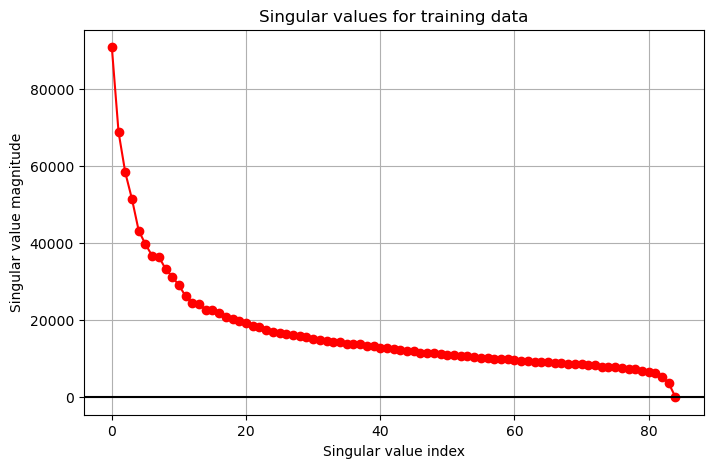

In [53]:
plt.plot(pca.model.singular_values_, "-o", color="red")
plt.xlabel("Singular value index")
plt.ylabel("Singular value magnitude")
plt.title("Singular values for training data")
plt.grid()
plt.axhline(0, color="black")
plt.show()

There is only one singular value that is equal to zero in this case. We can also plot ratio of the cumulative sum of these singular values, which gives the explained vario, over the total sum of all singular values to determine the ratio of the equation above:

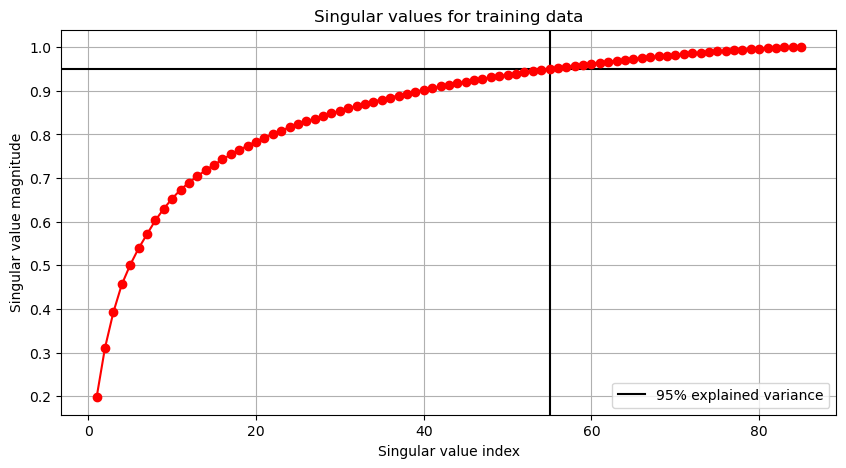

In [54]:
plt.figure(figsize = (10, 5))
# Get the cumulative sum of the explained variance
cumsum = np.cumsum(pca.model.explained_variance_ratio_)

# Plot the cumulative sum
plt.plot([i+1 for i in range(len(cumsum))], cumsum, "-o", color="red", zorder=100)

# For visualization, determine when we have 95% explained variance
for i, value in enumerate(cumsum):
    if value >= 0.95:
        break
plt.axhline(0.95, color="black")
plt.axvline(i + 1, color="black", label = "95% explained variance")
plt.xlabel("Singular value index")
plt.ylabel("Singular value magnitude")
plt.title("Singular values for training data")
plt.grid()
plt.legend(loc="lower right")
plt.show()

For the discussion below, we will initialize a default PCA feature extractor which uses 20 principal components. We will work in color, which might give worse results than using grayscale images since we have three times more "pixel variables", but working with color images allows for better visualizations. 

In [55]:
pca = PCAFeatureExtractor()
pca.fit(train_X)

### 1.2.1. Eigenface Plots

While fitting our PCA feature extractor to the training data, we also saved the __mean face__. Remember that PCA flattens the images into arrays of size $K^2$, and views the pixels as random variables. We can hence take the mean of each pixel over our training set, and end up with an array containing the mean of all pixels. By reshaping this mean array into an image of size $K\times K$, we can reconstruct this average as an image, and this average is called the mean face: it gives an average representation of a face, according to our training data.

In [60]:
if SHOW_PLOTS:
    plt.imshow(pca.meanface, cmap="Greys_r")
    plt.title("Mean face from training data")
    plt.show()

By fitting the PCA feature extractor, we keep a certain number of "principal components" which are either eigenvectors of the covariance matrix or vectors corresponding to singular values, according to the decomposition used in the PCA. Similar to the mean vector, we can reshape these eigenvectors into an image of size $K\times K$ and visualize them. When the training data consists of faces, these eigenvectors are often referred to as __eigenfaces__, since (when visualized) they resemble faces. These faces (vectors) are used to project images of faces onto a lower-dimensional representation, and due to their order, they maximize the amount of information they retain of the original faces. Below, we plot some of these eigenfaces, in order of decreasing singular values (hence, most important to least important).

In [59]:
nb_eigenfaces_to_show = pca.n_components
nb_per_row = 10
if SHOW_PLOTS:
    plot_image_sequence(pca.eigenfaces[0:nb_eigenfaces_to_show], imgs_per_row=nb_per_row)

### 1.2.2. Feature Space Plots

Since the projection of a data point by PCA on a lower-dimensional representation is reversible, we can compare an original image with its "reconstruction". That is, we project an image on its lower-dimensional representation, and apply the reverse transformation to get back an image of the original size. This can essentially be seen as a compression or reconstruction, as the new image is created from less information. The number of principal components determines the quality of the reconstructed image. Below, we show an example of such a reconstruction using 20 principal components.

In [65]:
# Take an example face to reconstruct
example_face = train_X[0]
# If we don't use color, convert to grayscale
if not pca.use_color:
    example_face = np.mean(example_face, axis=2)

# Plot the original face
if SHOW_PLOTS:
    fig, (ax0, ax1) = plt.subplots(1, 2)
    ax0.imshow(example_face.reshape(pca.shape), cmap="Greys_r")
    ax0.set_title("Original face")
    # Get reconstruction: first, project onto lower dimensonional repr
    reduced = pca.transform([example_face])
    # Then, reverse projection and reconstruct original
    reconstructed = pca.inverse_transform([reduced])[0]
    ax1.imshow(reconstructed, cmap="Greys_r")
    ax1.set_title(f"Reconstructed face (q = {pca.n_components})")

    plt.show()

As mentioned, the quality of this reconstruction depends on the amount of principal components to keep. Above, there are clear deviations between the original and reconstructed images. Below, we vary over the amount of principal components, below denoted by $q$, we use in the representation. This clearly shows that, while we clearly see only the mean face for low $q$, the reconstruction gradually uses more information of the face of interest, until the final images, with a high value of $q$, show hardly any difference with the original image. 

In [66]:
max_nb_components = 50
nb_per_row = 10

if SHOW_PLOTS:
    fig, axs = plt.subplots(max_nb_components//nb_per_row, nb_per_row, figsize = (15, 10))
    for nb_of_components in range(max_nb_components):
        # Get the current axis
        ax = axs[nb_of_components // nb_per_row, nb_of_components % nb_per_row]
        # Set number of principal components and recompute the projection matrix
        pca.n_components = nb_of_components+1
        pca.fit(train_X)
        # Compute the reconstruction
        reconstructed = pca.inverse_transform(pca.transform([example_face]))[0]
        # Plot it
        ax.imshow(reconstructed, cmap="Greys_r")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"q = {nb_of_components+1}")

    plt.show()

Of course, while we visually see that the difference between the original image and its reconstruction decreases, we want to have a method of quantifying this difference. One possible measure between the two images is the **root-mean-square deviation** (RMSD) between the two images, viewed as two arrays $\boldsymbol{x}$ and $\hat{\boldsymbol{x}}$ of size $K^2$. The RMSD measure is then defined as
\begin{equation*}
    RMSD(\boldsymbol{x}, \hat{\boldsymbol{x}}) = \sqrt{\frac{\sum_{i=1}^{K^2} (x_i - \hat{x}_i)}{K^2}}
\end{equation*}

In [67]:
def rmsd(x: np.array, x_hat: np.array):
    """
    Computes root mean square deviation between two Numpy arrays.
    """

    return np.sqrt(np.mean((x - x_hat)**2))

Now, we will again iterate over the number of principal components $q$ we keep in the PCA, and compute for each value of $q$ the average RMSD on the training set. This could give us insights into how much information is being retained by the PCA projection, and could *e.g.* inform us on which value of $q$ would be the most ideal to use in our classification pipeline.

*Note*: the following cell can take some time to evaluate, hence we "jump" in the number of components:

In [73]:
max_nb_components = 50
step_size = 5
n_components_list = np.arange(step_size, max_nb_components+1, step_size)
print(f"Number of components: {n_components_list}")

Number of components: [ 5 10 15 20 25 30 35 40 45 50]


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:45<00:00, 10.57s/it]


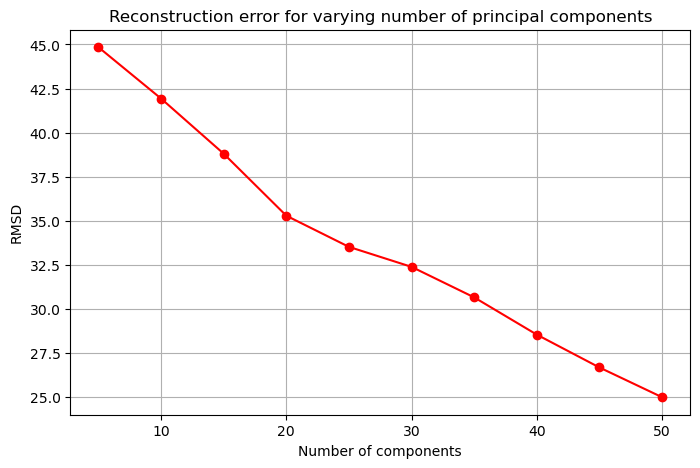

In [75]:
# Save the RMSD errors in a list
errors = []

# Check whether we train with grayscale or color images
if pca.use_color:
    original_data = train_X
else:
    # If we use grayscale, convert all the training images to grayscale as well
    original_data = np.array([np.mean(train_face, axis=2) for train_face in train_X])

for i in tqdm(range(len(n_components_list))):
    n_components = n_components_list[i]
    # Set number of principal components and recompute the projection matrix
    pca.n_components = n_components
    pca.fit(train_X)
    # Compute the reconstruction
    reconstructed_faces = pca.inverse_transform(pca.transform(original_data))
    error = np.mean([rmsd(original_data, reconstructed_faces)])
    # Append to list, make sure to reshape
    errors.append(error)

if SHOW_PLOTS:
    plt.plot(n_components_list, errors, '-o', color='red')
    plt.ylabel("RMSD")
    plt.xlabel("Number of components")
    plt.title("Reconstruction error for varying number of principal components")
    plt.grid()
    plt.show()

We can use this information to choose the number of principal components to keep for the classifier later on. For instance, we can consider the "gain" in RMSD when we increase the number of principal components to keep. Below, we plot for each value of $q$ the difference between the RMSD value with $q$ components and $q+1$ components. Together with the previous plot, we see that we have the best results for $q=40$ or $q=50$, so it would make sense to try different values of $q$ in the classification pipeline later on to tune this hyperparameter. We expect that, while the reconstruction loss goes steadily down for increasing number of principal components, having simpler features can be beneficial for the classifiers.

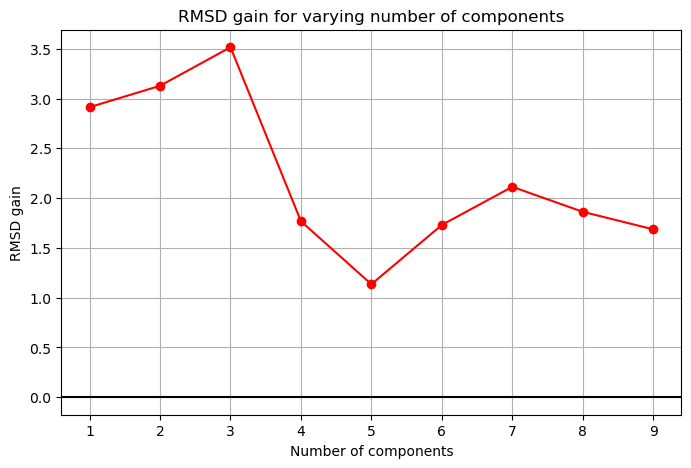

In [76]:
errors = np.array(errors)
next_errors = np.roll(errors, -1)
differences = errors - next_errors
if SHOW_PLOTS:
    plt.plot([i+1 for i in range(len(differences[:-1]))], differences[:-1], '-o', color='red')
    plt.ylabel("RMSD gain")
    plt.xlabel("Number of components")
    plt.title("RMSD gain for varying number of components")
    plt.axhline(0, color='black')
    plt.grid()
    plt.show()

A quantitative measure such as the RMSD is also a great way to compare our different face detectors and choose which preprocessed data is more suited for our use case here. It can also be used to tune the detectors: recall for instance that we defined an auxiliary function to modify the bounding boxes around faces: the hyperparameters involved in the detections can be tuned by their reconstruction error. However, this is beyond the scope of this tutorial.

#### Face-Feature Plots

Another great aspect about PCA is that we can create so-called **face-feature plots**, which can also be seen for instance in [this tutorial](https://sandipanweb.wordpress.com/2018/01/06/eigenfaces-and-a-simple-face-detector-with-pca-svd-in-python/). In a face-feature plot, we plot the different faces of the training set at locations that are determined by their features obtained from the PCA projection. For visualization purposes, we therefore restrict ourselves to $q = 2$, such that there are only two eigenfaces of interest. Applying the PCA projection on each image then gives us a 2D representation of the faces, which determine the location in the grid where we plot each image. 

In [77]:
pca.n_components = 2
pca.fit(train_X)

In [78]:
if SHOW_PLOTS:
    fig, ax = plt.subplots(figsize = (10,10))
    # Parameters to play with to increase/decrease the boxes of the faces in the plot
    delta_image = 0.25
    delta_plot = 0.5
    # Obtain the latent representations, i.e. after projecting with the PCA
    latent_reps = np.array([pca.transform([image]).flatten() for image in original_data])

    # Plot each image at their latent representation
    for i in range(train_X.shape[0]):
        image = train_X[i]
        latent = latent_reps[i]
        ax.imshow(image, interpolation='nearest', extent=(latent[0]-delta_image, latent[0]+delta_image, latent[1]-delta_image, latent[1]+delta_image), zorder=100)

    # Add annotations
    plt.xlim(latent_reps[:, 0].min()-delta_plot, latent_reps[:, 0].max()+delta_plot)
    plt.ylim(latent_reps[:, 1].min()-delta_plot, latent_reps[:, 1].max()+delta_plot)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Face-feature plot')
    plt.axhline(0, color="black")
    plt.axvline(0, color="black")
    plt.grid()
    plt.show()

Instead of plotting the faces, it is perhaps more informative to plot the class labels of the faces we extracted. This is done in the plot below, where black stands for class label 0, red for class label 1 and blue for class label 2.

In [79]:
if SHOW_PLOTS:
    fig = plt.figure(figsize = (10,10))
    # Parameters to play with to increase/decrease the plot window
    delta_plot = 0.5
    # Obtain the latent representations, i.e. after projecting with the PCA
    latent_reps = np.array([pca.transform([image]).flatten() for image in original_data])

    # Use colors instead of the faces
    colors = ["black", "red", "blue"]

    for i in range(original_data.shape[0]):
        image = original_data[i]
        latent = latent_reps[i]
        plt.scatter(latent[0], latent[1], color = colors[train_y[i]])

    # Annotate plot
    plt.xlim(latent_reps[:, 0].min()-delta_plot, latent_reps[:, 0].max()+delta_plot)
    plt.ylim(latent_reps[:, 1].min()-delta_plot, latent_reps[:, 1].max()+delta_plot)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Class labels plotted in PCA space')
    plt.axhline(0, color="black")
    plt.axvline(0, color="black")
    plt.grid()
    plt.show()

Apart from some data points, we see that the red and blue classes are well separated. However, the lookalikes, denoted by the black dots, are spread throughout the PCA space. However, we have take into account that this is a PCA representation based on only 2 principal components, which is very low and hence we expect the separation between classes to be quite poor. By increasing the amount of principal components, we can make the PCA features more discriminative

### 1.2.3. Discussion

As a quick recap, in this section we have seen how does PCA work, which options it provides to choose from depending on the starting data and what results it gives at every step of the process. One of the most critical choices that has to be made is the number of principal components, and for that, the **root-mean-square deviation (RMSD)** was used. This measure gives us a tool to calculate for every iteration on the number of principal components the *loss* of the reconstruction. For us, based on that procedure, the clear result was to avoid any values above 40, since there was no much information gained with higher numbers. In that way, the dimensionality of the feature space gets reduced while still being pretty informative.

Additionally, throughout the whole section different plots and graphs have been shown at each step to better understand how do the components of PCA work. Just before this discussion the face-feature plot is shown, and while the lookalikes are distributed over the whole PCA space, it is a normal behaviour since we are just using 2 principal components. The other classes, on the other hand, are clearly separated between them. Apart from that, another representative plot can be seen in the projection of the reconstructions of a face as the number of principal components increases.

# 2. Evaluation Metrics


The evaluation metrics used throughout the assignment are measures that give us the performance of the face recognition system as a whole. While there are other ones that provide us with the similarity or distance between predicted and true identities that might be used internally in different implemented methods or packages, we decided to just focus on those first ones. Below, we discuss these measures in the context of a binary classification problem for simplicity, with the two classes called positives and negatives.

## 2.2 Accuracy

The first one, which was already provided in the template, was **accuracy**. Accuracy gives us the ratio between the number of correct predictions and the total amount of predictions:
\begin{equation*}
    \text{accuracy}  = \frac{\text{TP} +\text{TN} }{\text{TP} +\text{TN} +\text{FP}+\text{FN} }
\end{equation*}
where TP stands for *true positives*, TN for *true negatives*, FP for *false positives* and FN for *false negatives*.

Although it is used a lot in classification, and it will also be used here, it has a couple of clear *disadvantages* that force us to use other measure as well. Its clearest flaw is its misleadingness when the data is imbalanced. When a class has many more examples than others, a classifier that always predicts the majority class would get a really high accuracy while in reality it would be quite poor if it cannot properly label any other class. However, accuracy it is still a decent starting point to measure the performance of a classifier. In our case, our class distributions are indeed not evenly balanced, but the degree of imbalance is relatively moderate and accuracy gives a rough estimate of a classifier's performance.



## 2.3 Precision

TODO

## 2.4 Recall

**Recall** tells us the performance of the system as the ratio between the true positives to the sum of those same ones and the false positives. It can be defined as
\begin{equation*}
    \text{recall}  = \frac{\text{TP} }{\text{TP} +\text{FN} }
\end{equation*}

his measure excels in situations where identifying all instance of a class is important and false negatives have notable consequences. A high score would indicate that the system is able to identify correctly most of the relevant instance of a class. However, in a similar fashion to the previous one, it has its flaws, and its main one is the tendency to give high scores to models that give a high number of false positives. That is why it is normally used in conjunction with other metrics such as the next one.

## 2.4 F1-score

The F1-score is the harmonic mean of precision and recall, which provides a balance between these two, and therefore, it gives us a better overview of the performance of the system together with the previously mentioned recall. It is calculated as follows:
\begin{equation*}
    f1 = \frac{2 \cdot \text{precision} \cdot \text{recall} }{\text{precision} +\text{recall}} = \frac{2  \text{TP}}{2  \text{TP}+\text{FP}+\text{FN}}
\end{equation*}

The score ranges between 0 and 1, as for the two previous ones as well, where 1 would mean perfect precision and recall. When there are no specific preferences towards better precision or better recall, the F1-score can be used to easily compare different models. The one that has the higher F1-score being the better-performing one. Therefore, it is really useful in our case when trying to come up with different classifiers and different ways of getting feature representations.

## 2.5 Confusion matrix

While the previous discussion relied on a binary classification problem as example, our face recognition application is actually a multi-class classification problem where there are three possible labels: *1* for *Jesse*, *2* for *Mila* and *0* for their lookalikes. For multi-class classification problems, confusion matrices are convenient to estimate the performance of a classifier. A **confusion matrix** is a table where the differences between the true labels and the predicted ones for each class can be seen. Therefore, it is one of the most useful metrics/tools can we can use. Its structure would be like this:
<table>
  <tr>
    <th></th>
    <th>Actual Label 1</th>
    <th>Actual Label 2</th>
    <th>Actual Label 3</th>
  </tr>
  <tr>
    <td><strong>Predicted Label 1</strong></td>
    <td>TP for Label 1</td>
    <td>FP for Label 1</td>
    <td>FP for Label 1</td>
  </tr>
  <tr>
    <td><strong>Predicted Label 2</strong></td>
    <td>FN for Label 2</td>
    <td>TP for Label 2</td>
    <td>FP for Label 2</td>
  </tr>
  <tr>
    <td><strong>Predicted Label 3</strong></td>
    <td>FN for Label 3</td>
    <td>FN for Label 3</td>
    <td>TP for Label 3</td>
  </tr>
</table>


This matrix is where the previous metrics get calculated from, but it is also a great tool of evaluating the different models on its own. You can easily tell for each case what the main problems and strengths might be if you are getting low or high scores in any of the previous measures.

# 3. Classifiers

In the previous section, we extracted features out of the image data of the faces of the training set. These features can then serve as input for various classification methods, which then try to learn to identify the different classes (recognize the different faces) based solely on their feature representations. In this section, we will explore classifying our faces with our handcrafted SIFT and PCA features with various classification methods. 

There are many possible classifiers that can be used for our classification problem. Below, we use a support vector machine (SVM) classifier for the SIFT and PCA features that we extracted above. For another tutorial on how to use an SVM for face recognition, see [here](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html). We also briefly explore a fully-connected neural network as alternative to the SVM. Finally, we will explore VGG-16 as a classifier, which achieves a superior performance due to the fact that this architecture was trained on much more data, and moreover, uses features obtained using deep learning on a larger training set. 

First, we define a general pipeline that can be used by any feature extractor and any classifier trained on those features. The function takes a preprocessed image as an input (for the test data, we preprocessed the data before and saved a path to the location of all the preprocessed data), as well as a feature extractor and a classifier.

In [81]:
def prediction_pipeline(feature_extractor, classifier, path=test_prep_X_loc):
    """
    Simple prediction pipeline in case we load in the preprocessed test data.
    Args:
        feature_extractor (Any): The feature extractor used to extract features out of faces.
        classifier (Any): The classifier trained to classify based on the features extracted by feature_extractor.
        path (str, optional): Location of the directory containing the preprocessed test data to load and classify.
    """
    # Path points to a directory where preprocessed test data is located
    
    y_pred = []
    
    # Get the number of files
    nb_of_files = len(os.listdir(test_prep_X_loc))
    for i in tqdm(range(nb_of_files)):
        img = np.load(os.path.join(path, f"test_{i}.npy"))
        # Get the features using the extractor
        features = feature_extractor([img])
        # Make the predictions
        new_pred = classifier(features)
        y_pred.append(new_pred)
        
    return y_pred

We also define an auxiliary function that takes care of converting the predictions we made above to a CSV file for submitting to the Kaggle competition.

In [82]:
def predictions_to_csv(predictions: np.array, name: str  = 'submission.csv'):
    """
    Auxiliary function that creates a CSV submission file based on predictions made for the test set.
    Args:
        predictions (np.array): Predictions made on the test set.
        name (str, optional): Name of the submission CSV file. Defaults to submission.csv
    """
    submission = test.copy().drop('img', axis = 1)
    submission['class'] = predictions
    submission.to_csv(name)
    
    return 

We will also give names to the classes

In [96]:
target_names = ["0", "1", "2"]

### 3.1 SVM Classifier based on PCA Features

We begin with an SVM classifier based on the PCA features discussed above. An SVM, or Support Vector Machine, is a classifier that maximizes the distance between two classes when they are linearly separable. When data is not linearly separable, a kernel is applied to transform the data in such a way that a linear decision boundary can still be found. Our aim is that with the SIFT and PCA features, we can find a linear separation between the features of Jesse Eisenberg and Mila Kunis. For that purpose, we use a radial basis function (RBF) kernel (also known as Gaussian kernel) below.

For a more general info on the use of SVMs in the context of face recognition, see [this tutorial](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html).

In [88]:
class SVM_PCA_classifier:
    """
    Implements an SVM classifier using the PCA features.
    """

    def __init__(self):
        # The model will be fitted layer on
        self.model = None


    def fit(self, X: np.array, y: np.array, verbose: bool = True):
        """
        Fit the SVM with the given data.
        Args:
            X (np.array): Input data for the classifier.
            y (np.array): Output data of the classifier.
            verbose (bool, optional): Show optimal SVM parameters. Defaults to False.
        """

        # Find the best SVM parameters for a 
        param_grid = {
            "C": loguniform(1e-1, 1e5),
            "gamma": loguniform(1e-7, 1e2),
        }
        clf = RandomizedSearchCV(
            SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=500
        )
        clf = clf.fit(X, y)
        if verbose:
            print(clf.best_estimator_)

        # Save the best model
        self.model = clf.best_estimator_

    def predict(self, X):
        return self.model.predict(X)

    def __call__(self, X):
        return self.predict(X)

Below, we demonstrate the workings of the classifier. First, we transform the input data to obtain their features, after which we perform a train-test-split to have a validation set to check the results of the classifier.

In [89]:
# Fit a PCA extractor
n_components = 40
pca = PCAFeatureExtractor(n_components = n_components, use_color=True)
pca.fit(train_X)
# Obtain feature representations
train_X_pca = pca.transform(train_X)
# Perform train test split
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    train_X_pca, train_y, test_size=0.25, random_state=42
)

Now, we will use the above training data to fit the SVM classifier.

In [90]:
svm_pca_classifier = SVM_PCA_classifier()
svm_pca_classifier.fit(X_train_pca, y_train_pca)

SVC(C=17.074142799899352, class_weight='balanced', gamma=0.0013884135127996701)


After training, we can check the results by looking at the performance on the hold-out set. Below we see the results on the PCA features in the form of a **confusion matrix**. In all of our results we note the confusion matrix rather than just the accuracy as in a classification task, accuracy can be misleading for imbalanced classes. Rather we look at the f1-score, which is the average of the precision and recall. In our case, the training data that we will be using our classification methods on have balanced classes, but the confusion matrix allows us to see the classification f1-score on each class individually. This will allow us to determine if our features or our model are more distinguishable on a specific class.

Below we see that the SVM Classifier on the PCA features have a fairly evenly distributed f1-score between all 3 classes. The average f1-score on this classifier is .82

In [99]:
# Make the predictions on the test set (validation set)
pred_y = svm_pca_classifier.predict(X_test_pca)

# Print a classification report and show confusion matrix
cr = classification_report(y_test_pca, pred_y, target_names=target_names)
print(cr)
if SHOW_PLOTS:
    ConfusionMatrixDisplay.from_predictions(y_test_pca, pred_y, xticks_rotation="vertical")
    # Add title and tidy up
    classifier_name = "SVM with PCA"
    plt.title("Confusion matrix for " + classifier_name)
    plt.tight_layout()
    plt.show()

              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.69      1.00      0.82         9
           2       1.00      0.50      0.67         6

    accuracy                           0.82        22
   macro avg       0.90      0.79      0.80        22
weighted avg       0.87      0.82      0.81        22



### 3.2 SVM Classifier based on SIFT Features

Similarly, we use an SVM Classifier on the handcrafted SIFT Features.

In order to perform classification on the SIFT Features, we must first create a 'bag of visual words' model. In this scenario, we use K-means clustering to form clusters of features that are distinguishable from each other. The visual features are analogous to words as with this model we create a dictionary where we assign one word to each cluster. Thus each distinguishable feature should be mapped to a specific cluster which will ideally allow the SVM model to group clusters together according to who they identify.

In [101]:
class SVM_SIFT_Classifier:
    """
    SVM classifier using the SIFT features.
    """

    def __init__(self, k: int):
        """
        Initialization.
        Args:
            k (int): Hyperparameter for mini batch k means.
        """
        self.k = k
        self.hist = None
        self.clp = None
        self.kmeans = None

    def flatten(self, arr):
        """
        Flatten descriptors to two dimensions
        Args:
            arr (np.array): The SIFT descriptors
        """
        all_descriptors = []
        for img_descriptors in arr:
            # get each feature from image
            for descriptor in img_descriptors:
                all_descriptors.append(descriptor)
        all_descriptors = np.stack(all_descriptors)
        return all_descriptors

    def fit(self, desc):
        """
        Fit data with mini batch k means
        Args:
            desc (np.array): SIFT descriptors
        """
        flattened_desc = self.flatten(desc)
        kmeans = MiniBatchKMeans(n_clusters=self.k, batch_size=20).fit(flattened_desc)
        self.kmeans = kmeans

    def histogram(self, all_kp, all_desc):
        """
        Cluster data into histograms based on prediction.
        Args:
            all_kp (np.array): All keypoints for SIFT
            all_desc (np.array): All descriptors for SIFT
        """
        hist = []
        for i in range(len(all_desc)):
            hist_i = np.zeros(self.k)
            nkp = np.size(all_kp[i])

            for d in all_desc[i]:
                idx = self.kmeans.predict([d])
                hist_i[idx] +=1/nkp
            hist.append(hist_i)
        self.hist = hist
        return hist

    def train(self, train_hist, train_y, verbose = True):
        """
        Train the classifier
        Args:
            train_hist (np.array): Histogram
            train_y (np.array): Targets
            verbose (bool, optional): Print progress. Defaults to False.
        """
        # Perform grid search to find optimal SVM parameters
        param_grid = {
            "C": loguniform(1e-1, 1e5),
            "gamma": loguniform(1e-7, 1e2),
        }
        clf = RandomizedSearchCV(
            SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=500)
        start = time.time()
        clf = clf.fit(np.array(train_hist), train_y)
        end = time.time()
        if verbose:
            print("Done in %0.3fs" % (end - start))
            print("Best estimator found by grid search:")
            print(clf.best_estimator_)
        # Save best classifier
        self.clf = clf
        return clf

As before, we first collect the SIFT Features for our classification problem and perform a train-test-split.

In [102]:
# Create instance of the classifier
classifier = SVM_SIFT_Classifier(10)

# split training data
X_train_sift, X_test_sift, y_train_sift, y_test_sift = train_test_split(
    train_X, train_y, test_size=0.25, random_state=42
)

# get descriptors and keypoints of train data
train_des, train_kp = SIFTExtractor.detect_and_compute(X_train_sift)
classifier.fit(train_des)
# cluster training points by their keypoints
train_hist = classifier.histogram(train_kp, train_des)
# train
clf = classifier.train(train_hist, y_train_sift)

# get desscriptors and keypoints of test data
test_des, test_kp = SIFTExtractor.detect_and_compute(X_test_sift)
# cluster test data by keypoints
test_hist = classifier.histogram(test_kp, test_des)

done in 10.819s
Best estimator found by grid search:
SVC(C=5.5474613134349795, class_weight='balanced', gamma=1.3078854145134327)


We now again turn to the prediction stage. We note that the SIFT Features result in lower performance with SVM than the PCA Features. The average F1-score is .55

This lower score can either be attributed to the fact that an SVM classsifier may not be the best model for SIFT features, or that the SIFT Features are less distinguishable than the PCA Features. We will investigate this issue by using another classifier.

In [105]:
# make predictions
pred_y = classifier.clf.predict(test_hist)

# Show report
cr = classification_report(y_test_sift, pred_y)
print(cr)
if SHOW_PLOTS:
    ConfusionMatrixDisplay.from_predictions(y_test_sift, pred_y, xticks_rotation="vertical")
    # Add title and tidy up
    classifier_name = "SVM with SIFT"
    plt.title("Confusion matrix for " + classifier_name)
    plt.tight_layout()
    plt.show()

              precision    recall  f1-score   support

           0       0.50      0.71      0.59         7
           1       0.60      0.33      0.43         9
           2       0.71      0.83      0.77         6

    accuracy                           0.59        22
   macro avg       0.60      0.63      0.60        22
weighted avg       0.60      0.59      0.57        22



### 3.3 RandomForest Classifer

Next we try a random forest classifier from sklearn. SVM Classifiers are more performant on binary classification tasks. Since our problem is multi-task, we expect the RandomForest Classifier to perform better.

A random forest classifier is an ensemble method of classification such that it combines predictions from multiple decision trees. Each decision tree uses a random subset of the training data and features, hence the name 'random' forest. In this way, the random forest classifier should account for overfitting and lead to better performance especially on small datasets where overfitting is common.

We tune the `max_depth` parameter in order to obtain the best results for our data. Selecting a large number can lead to overfitting, while a small number can lead to underfitting.

Afterwards, we use the random forest classifier for both the SIFT and PCA feature representations of the data.

In [106]:
class BestModel:

    def __init__(self):
        self.model = None

    def fit(self, X, y):
        self.model = RandomForestClassifier(max_depth=6, random_state=1)
        self.model.fit(X, y)


    def predict(self, X):
        return self.model.predict(X)

### 3.3.1 RandomForestClassifier based on SIFT Features

We start by modeling the classier on the SIFT Features

In [107]:
sift_search_classifier = BestModel()
sift_search_classifier.fit(np.array(train_hist), y_train_sift)

In the predictions that follow, we note that the average f1-score did not improve but the metrics for Class 1 and Class 2 improved. These are the classes for Jesse Eisenberg and Mila Kunis which are the two classes that we wish to most accurately discriminate. However the lower score on Class 0 means that the random forest classsifier classifies 'lookalikes' less accurately.

In [1]:
pred_y = sift_search_classifier.predict(test_hist)

# Show report
cr = classification_report(y_test_sift, pred_y)
print(cr)
if SHOW_PLOTS:
    ConfusionMatrixDisplay.from_predictions(y_test_sift, pred_y, xticks_rotation="vertical")
    # Add title and tidy up
    classifier_name = "random forest with SIFT"
    plt.title("Confusion matrix for " + classifier_name)
    plt.tight_layout()
    plt.show()

NameError: name 'sift_search_classifier' is not defined

### 3.3.2 Random Forest Classifer based on PCA features

Next we use the classifier on the PCA features

In [110]:
pca_classifier = BestModel()
aml = pca_classifier.fit(X_train_pca, y_train_pca)

As we predicted, our RandomForest classifer performs better on PCA Features than the SVM classifier, with an average f1-score of .86

In [111]:
pred_y = pca_classifier.model.predict(X_test_pca)

# Show report
cr = classification_report(y_test_pca, pred_y)
print(cr)
if SHOW_PLOTS:
    ConfusionMatrixDisplay.from_predictions(y_test_pca, pred_y, xticks_rotation="vertical")
    # Add title and tidy up
    classifier_name = "random forest with PCA"
    plt.title("Confusion matrix for " + classifier_name)
    plt.tight_layout()
    plt.show()

              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.88      0.78      0.82         9
           2       0.75      1.00      0.86         6

    accuracy                           0.86        22
   macro avg       0.88      0.88      0.87        22
weighted avg       0.88      0.86      0.86        22



### 3.4 Cross Validation
Since our training dataset is so small with only 85 examples, we believe our classifier may be dropping in performance due to overfitting. Another method to prevent overfitting is cross validation. Cross validation splits the datatset into partitions and performs a train_test split on each partition and takes an average of all of the results.
We note that cross validation does not improve the performance of the RandomForest Classifier on PCA features. The average f1-score seen below is .82 compared to .86 with the RandomForest classifier without cross validation. This is understandable as the RandomForest classifier already introduces random subsets of the training data, thus it already improves on the issue of overfitting seen with small datasets.

Cross validation was also experimeted on the SIFT features, however it did not affect the scores so it is not shown in this demonstration.

In [113]:
y_pred = cross_val_predict(pca_classifier.model, train_X_pca, train_y, cv=3)
cr = classification_report(train_y, y_pred)
print(cr)
if SHOW_PLOTS:
    ConfusionMatrixDisplay.from_predictions(train_y, y_pred, xticks_rotation="vertical")
    # Add title and tidy up
    classifier_name = "random forest with PCA, cross-validation"
    plt.title("Confusion matrix for " + classifier_name)
    plt.tight_layout()
    plt.show()

              precision    recall  f1-score   support

           0       0.89      0.70      0.78        23
           1       0.88      0.77      0.82        30
           2       0.76      0.97      0.85        32

    accuracy                           0.82        85
   macro avg       0.84      0.81      0.82        85
weighted avg       0.84      0.82      0.82        85



### 3.4 Ensemble Classification

A final method to improve on our SVM classification methods discussed above is to combine the predictions from both the SIFT classifier and the PCA classifier in a so-called **ensemble method**. The SIFT and PCA features may highlight different aspects of each person. So ideally creating this ensemble classifier allows us to combine both feature types to benefit from each of their best features. Our ensemble classifier results in an f1-score of .64, thus this classifier is still combining some incorrect classifications from the SIFT and PCA classifiers.

From the results that follow, we see that our ensemble classifier performs the best on class 2. This means that the PCA and SIFT classifiers agreed on the most images of Mila Kunis. While the ensemble classifier performs the worst on class 1.

In [114]:
pred_proba_sift = sift_search_classifier.model.predict_proba(np.array(test_hist))
pred_proba_pca = pca_classifier.model.predict_proba(X_test_pca)

combined_pred_proba = (pred_proba_pca + pred_proba_sift) /2
combined_pred = np.argmax(combined_pred_proba, axis=1)

cr = classification_report(y_test_pca, combined_pred)
print(cr)
if SHOW_PLOTS:
    ConfusionMatrixDisplay.from_predictions(y_test_pca, combined_pred, xticks_rotation="vertical")
    # Add title and tidy up
    classifier_name = "ensemble method"
    plt.title("Confusion matrix for " + classifier_name)
    plt.tight_layout()
    plt.show()

              precision    recall  f1-score   support

           0       0.50      0.57      0.53         7
           1       0.60      0.33      0.43         9
           2       0.56      0.83      0.67         6

    accuracy                           0.55        22
   macro avg       0.55      0.58      0.54        22
weighted avg       0.56      0.55      0.53        22



### 3.5 Simple feedforward MLP

Before we turn our attention to the final and most effective classifier, the VGG network, we discuss a simple neural network architecture as build-up. That is, we use a fully-connected (dense) **feedforward multilayer perceptron** (MLP), which takes our handcrafted features as input features, and propagates them through a few hidden layers to compute an output. In our case, the output will consist of three nodes that represent the probabilities that a given feature representation corresponds to the given classes 0, 1, 2. We will demonstrate the inner workings of neural networks using the PyTorch library. For our purpose, one can choose whether to convert the targets, *i.e.* the class labels, to 3D vectors for this purpose using the auxiliary function defined below, although PyTorch is able to handle both representations.

In [115]:
def create_vector_data(labels: np.array, size: int=3):
    """
    Turns an array of class labels into an array of 3D vectors representing probabilities.
    Args:
        labels (np.array): Class labels (target data)
        size (int, optional): Number of different class labels. Defaults to 3 for our application.
    Returns:
        np.array: New labels, representing the distributions.
    """
    new_labels = []
    for label in labels:
        # Put zeroes everywhere
        new_label = np.zeros(size)
        # Put a one in the index location corresponding to the label
        new_label[label] = 1
        new_labels.append(new_label)
        
    return np.array(new_labels)

The PyTorch library allows user to create their own datasets to process data in PyTorch networks. Hence, we define a custom dataset class that is specifically catered towards our face recognition application. Note that, when loading in the data, we normalize the input data, which is good practice especially when dealing with high-dimensional data.

In [116]:
class CustomDataset(Dataset):
    """
    Custom data set to process the input features and output labels of our data.
    """

    def __init__(self, features: np.array, labels: np.array, to_vector: bool = False, normalization_function: Callable = None) -> None:
        """
        Initializes the class by separating data into features and labels.
        Args:
            features (np.array): Array containing the input data.
            labels (np.array): Array containing the output data.
            to_vector (bool, optional): Indicate whether we train with class labels as targets or convert to probabilities. Defaults to False.
            normalization_function (Callable, optional): Function that normalizes the input features, for instance with scikit-learn. Defaults to None (no normalization performed).
        """
        # Normalize input data if given a normalization function to perform
        if normalization_function is not None:
            features = normalization_function(features)

        # Convert features to Torch tensors for PyTorch
        features = torch.from_numpy(features)
        # Turn into probabilities if desired (not recommended according to PyTorch docs)
        if to_vector:
            labels = create_vector_data(labels)
        # Convert labels to Torch tensors
        labels = torch.from_numpy(labels)

        # Save as instance variables to the dataloader
        self.features = features
        self.labels   = labels

    def __len__(self):
        """Get the length of the dataset."""
        return len(self.labels)

    def __getitem__(self, idx: int) :
        """
        Gets an item from the dataset based on a specified index.
        Args:
            idx: (int): Index used to fetch the item.
        Returns:
            tuple[torch.Tensor, torch.Tensor]: Tuple of feature and its corresponding label.
        """
        # Get the feature, but normalized
        feature = self.features[idx]

        # Get the label
        label = self.labels[idx]
        return feature, label

For this demonstration, we will use the features extracted by a PCA analysis (see above for the extraction and train test split).

In [ ]:
# # Choose number of components
# n_components = 50
# # Define and fit the PCA extractor
# pca = PCAFeatureExtractor(n_components = n_components)
# pca.fit(train_X)
# # Choose between color and grayscale images
# if pca.use_color:
#     original_data = train_X
# else:
#     original_data = np.array([np.mean(train_face, axis=2) for train_face in train_X])
# # Get the transformed data of training data
# train_X_pca = pca.transform(original_data)
# # Perform train test split
# X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
#     train_X_pca, train_y, test_size=0.25, random_state=42
# )

As already mentioned, we will normalize the data through scikit-learn's StandardScaler. We fit the scaler on the training data and use the same transformation to scale the test data. Normalizing the input features is crucial to ensure that the network trains efficiently and to improve the stability of the training process. 

In [117]:
# Define StandardScaler object
scaler = StandardScaler()
# Convert to PyTorch Datasets as we defined them, normalize with same transformation as on training data
train_dataset = CustomDataset(X_train_pca, y_train_pca, normalization_function = scaler.fit_transform) 
test_dataset  = CustomDataset(X_test_pca, y_test_pca, normalization_function = scaler.transform)
# Then we create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=1)
test_dataloader  = DataLoader(test_dataset, batch_size=1)

We will now define our architecture. The architecture can easily accomodate for various setups of the hidden layers and their sizes. The user can also specify different activation functions, with the default one being the rectified linear unit (ReLU), which is often used. The output of the network uses a **softmax layer**, which models a multinomial probability distribution and is hence the ideal activation function for a multiclass classification problems. Applying an argmax operation to the output of the network can turn these probabilities into a prediction.

In [118]:
class FeedForwardNet(nn.Module):
    """
    Implements a simple feedforward neural network for our multiclass classification problem of face recognition.
    """
    def __init__(self, nb_of_inputs: int, nb_of_outputs: int = 3, h: list = [200, 200, 200], activation_function: Callable = torch.nn.ReLU) -> None:
        """
        Initialize the neural network class.
        Args:
            nb_of_inputs (int): Number of input nodes for the network, i.e. the number of features.
            nb_of_outputs (int, optional): Number of output nodes for the softmax layer. Defaults to 3.
            h (list, optional): List representing the setup of the hidden layers by specifying the number of hidden neurons per layer. Defaults to [200, 200, 200].
            activation_function (Callable, optional): Activation function for the hidden layers. Defaults to the ReLU activation function.  
        """
        
        self.h = h
        # Call the super constructor first
        super(FeedForwardNet, self).__init__()
        
        # Add visible layers as well to get all layer sizes
        self.h_augmented = [nb_of_inputs] + h + [nb_of_outputs]

        # Define the layers:
        for i in range(len(self.h_augmented)-1):
            if i == len(self.h_augmented)-2:
                # For the final output layer, apply softmax
                setattr(self, f"linear{i+1}", nn.Linear(self.h_augmented[i], self.h_augmented[i+1], bias=False))
                setattr(self, f"softmax", nn.Softmax())  
            else:
                # For intermediate layers, apply the specified activation function
                setattr(self, f"linear{i+1}", nn.Linear(self.h_augmented[i], self.h_augmented[i+1]))
                setattr(self, f"activation{i+1}", activation_function())

    def forward(self, x):
        """
        Computes a single forward step given the input x.
        Args:
            x (torch.Tensor): Input for the neural network.
        Returns:
            torch.Tensor: Output of the network.
        """

        for i, module in enumerate(self.modules()):
            # The first module is the whole network, so continue
            if i == 0:
                continue
            # For each of our defined layers, "apply" the layer
            x = module(x)

        return x

Now that the architecture is defined, we will define a **train loop**, in wich the neural networks' parameters get adjusted, and a **test loop**, where the weights are frozen and we compute the loss on the train and test set to monitor the training.

In [119]:
def train_loop(dataloader: DataLoader, model: FeedForwardNet, loss_fn: Callable, optimizer: Callable) -> None:
    """
    Does one epoch of the training loop.
    Args:
        dataloader (DataLoader): Torch DataLoader object, containing training data.
        model (FeedForwardNet): An instance of our neural network.
        loss_fn (Callable): The loss function used during training.
        optimizer (Callable): The optimizer used during training.
    """
    size = len(dataloader.dataset)
    # Go over the data in the dataloader
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction 
        prediction = model(X)
        # Compute loss 
        loss = loss_fn(prediction, y)

        # Do the backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test_loop(dataloader: DataLoader, model: FeedForwardNet, loss_fn: Callable) -> float:
    """
    The testing loop to compute the loss.
    Args:
        dataloader (DataLoader): Torch DataLoader object, containing training data.
        model (FeedForwardNet): An instance of our neural network.
        loss_fn (Callable): The loss function used during training.
        optimizer (Callable): The optimizer used during training.
    Returns:
        float: Loss computed on the provided data.
    """

    # Get the number of batches
    num_batches = len(dataloader)
    # Initialize loss
    test_loss = 0

    # Predict and compute loss, add to total loss
    with torch.no_grad():
        for X, y in dataloader:
            prediction = model(X)
            test_loss += loss_fn(prediction, y).item()

    # Return the average of the loss over the number of batches
    return test_loss / num_batches

Imbalanced data can disrupt the training and effectiveness of the classifier. While the training data is not too imbalanced, we will take the class distributions into account when training the MLP, since that will be easy to achieve with PyTorch.

In [120]:
# Get class distributions of the training data
counts = np.array([len(train_improved[train_improved["class"] == i]) for i in [0,1,2]])
probabilities = counts/np.sum(counts)
probabilities = torch.from_numpy(probabilities)
probabilities

tensor([0.2706, 0.3529, 0.3765], dtype=torch.float64)

We now implement a class which unites all training aspects and also saves the losses obtained during training to conveniently plot the training afterwards. The train method implemented in this class also uses **early stopping**, a commonly used regularization method, and implements a simple DIY adaptive learning rate scheme.

In [121]:
class Trainer:
    """
    Class that implements all training aspects.
    """

    def __init__(self, model: FeedForwardNet, learning_rate: float, train_dataloader: DataLoader, test_dataloader: DataLoader, 
                 loss_fn: Callable, optimizer: Callable) -> None:
        """
        Initialization of class.
        Args:
            model (FeedForwardNet): An instance of our network.
            learning_rate (float): Initial learning rate for the network.
            train_dataloader (DataLoader): DataLoader for the training data.
            test_dataloader (DataLoader): DataLoader for the test data.
            loss_fn (Callable): The loss function used during training.
            optimizer (Callable): The optimizer used during training.
        """

        # Save everything as class variables
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.model = model
        self.best_model = model
        self.loss_fn = loss_fn
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        # Create empty lists to store the train and test lossees
        self.train_losses = []
        self.test_losses = []
        

    def train(self, number_of_epochs: int = 500, patience: int = 10, patience_delta: float = 0.01, 
              adaptation_threshold: float = 0.9995, adaptation_multiplier: float = 0.5, verbose: bool = False) -> None:
        """
        Train the network using early stopping and with an adaptive learning rate.
        Args:
            number_of_epochs (int, optional): Maximum number of epochs to train the network. Defaults to 500.
            patience (int, optional): Number of epochs before we exit training due to early stopping criterion. Defaults to 10.
            patience_delta (float, optional): Threshold when comparing test loss for early stopping criterion. Defaults to 0.01.
            adaptation_threshold (float, optional): Threshold for the adaptive learning rate. Defaults to 0.9995.
            adaptation_multiplier (float, optional): Multiplier reducing the learning rate if desired. Defaults to 0.5.
            verbose (bool, optional): Print epochs and losses during training. Defaults to False.
        """
        
        # Initialize variables
        best_loss = np.inf
        # Counter for early stopping will have a "burn in" period
        stopping_counter = -10

        # Epoch counter for this specific training session
        epoch_counter = 0  
        # In case we continue training, the total number of epochs depends on train losses already saved
        total_epoch_counter = len(self.train_losses) + 1 

        # The counter makes sure we do not update the learning rate too often
        # if the network was not trained yet, first 5 epochs we don't change the learning rate
        if len(self.train_losses) == 0:
            counter = -5
        else:
            counter = 0

        # Keep on continuing the training until we hit max number of epochs
        while epoch_counter < number_of_epochs:
            # Train the network
            train_loop(self.train_dataloader, self.model, self.loss_fn, self.optimizer)
            # Test on the training data to get performance
            average_train_loss = test_loop(self.train_dataloader, self.model, self.loss_fn)
            self.train_losses.append(average_train_loss)
            # Test on testing data to get performance
            average_test_loss = test_loop(self.test_dataloader, self.model, self.loss_fn)
            self.test_losses.append(average_test_loss)
            
            # Print progress (if desired)
            if verbose:
                print(f"--- Epoch {epoch_counter} ---")
                print(f"Train loss: {average_train_loss}")
                print(f"Test   loss: {average_test_loss}")

            ## Adaptive learning rate
            # Adapt the learning rate after 10 epochs (burn-in period)
            if counter >= 10:
                # Compare previous and recent train losses
                current = np.min(self.train_losses[-5:])
                previous = np.min(self.train_losses[-10:-5])

                # If we did not improve the test loss sufficiently, adapt learning rate
                if current / previous >= adaptation_threshold:
                    # Reset counter (note: we will increment later, so set to -1 st it becomes 0)
                    counter = -1
                    self.learning_rate = adaptation_multiplier * self.learning_rate
                    # Change optimizer
                    optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
                    self.optimizer = optimizer
                    
            ## Early stopping
            # Check if the validation loss has improved
            if average_test_loss < best_loss:
                best_loss = average_test_loss
                self.best_model = self.model
                stopping_counter = 0
            else:
                # Perform early stopping if there was no improvement after a certain number of timesteps
                if average_test_loss > best_loss + patience_delta:
                    stopping_counter += 1
                    if stopping_counter >= patience:
                        print('Early stopping after {} epochs'.format(epoch_counter + 1))
                        break

            # Another epoch passed - increment overall counters
            counter += 1
            epoch_counter += 1

        print("Training done!")

Now, we are ready to train an instance of our MLP classifier:

In [131]:
# Define an instance of our network, make sure the input matches the number of PCA components
net = FeedForwardNet(nb_of_inputs = pca.n_components, h=[100, 20]).double()
print(net)
# Initialize optimizer and Trainer
learning_rate = 0.001
loss_fn = torch.nn.CrossEntropyLoss(weight=probabilities)
optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate)
trainer = Trainer(net, learning_rate, train_dataloader, test_dataloader, loss_fn, optimizer)

FeedForwardNet(
  (linear1): Linear(in_features=40, out_features=100, bias=True)
  (activation1): ReLU()
  (linear2): Linear(in_features=100, out_features=20, bias=True)
  (activation2): ReLU()
  (linear3): Linear(in_features=20, out_features=3, bias=False)
  (softmax): Softmax(dim=None)
)


In [132]:
trainer.train(number_of_epochs=500)

Training done!


Make a plot of the losses to monitor the training process:

In [138]:
if SHOW_PLOTS:
    plt.plot([i+1 for i in range(len(trainer.train_losses))], trainer.train_losses, '-o', color="red", label="Train")
    plt.plot([i+1 for i in range(len(trainer.test_losses))], trainer.test_losses, '-o', color="blue", label="Test")
    plt.grid()
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training of feedforward MLP")
    plt.show()

Now that we have a trained model, we can put everything into a classifier class for the prediction pipeline.

In [139]:
class FeedForwardClassifier:
    """
    Implements a classifier with a simple feedforward MLP.
    """

    def __init__(self, net: FeedForwardNet, scaler: StandardScaler):
        """
        Initializes the classifier with a network and a normalizer.
        Args:
            net (FeedForwardNet): A trained feedforward MLP classifier with softmax output layer.
            scaler (StandardScaler): StandardScaler which normalizes the input data.
        """
        self.net = net
        self.scaler = scaler

    def fit(self, X, y):
        """Classifier takes already fitted model"""
        pass

    def predict(self, X: np.array) -> np.array:
        # Disable torch's gradient (backpropagation) for predictions
        with torch.no_grad():
            # Perform normalization
            X = self.scaler.transform(X)
            # Make the prediction
            y_pred = self.net(torch.from_numpy(X))
            y_pred = torch.argmax(y_pred, axis=1).numpy()
            # In case we have only a single value, convert array to int
            if len(y_pred) == 1:
                y_pred = y_pred[0]
        return y_pred

    def __call__(self, X):
        return self.predict(X)

We again analyze the performance with the classification report and confusion matrix.

In [142]:
classifier = FeedForwardClassifier(net, scaler)
# Make the predictions on the test set (validation set)
pred_y = classifier(X_test_pca)

# Print a classification report and show confusion matrix
cr = classification_report(y_test_pca, pred_y)
print(cr)
if SHOW_PLOTS:
    ConfusionMatrixDisplay.from_predictions(y_test_pca, pred_y, xticks_rotation="vertical")
    # Add title and tidy up
    classifier_name = "MLP with PCA"
    plt.title("Confusion matrix for " + classifier_name)
    plt.tight_layout()
    plt.show()

              precision    recall  f1-score   support

           0       1.00      0.43      0.60         7
           1       0.69      1.00      0.82         9
           2       0.67      0.67      0.67         6

    accuracy                           0.73        22
   macro avg       0.79      0.70      0.69        22
weighted avg       0.78      0.73      0.71        22



## 3.1. Baseline 2: Transfer learning CNN

TODO - add discussion and documentation. **Note**, for actually using it, I suggest we skip the discussion on the train data etc and just show how to directly use it on the test data since we can just explain why it's going to improve upon the methods above to finish the whole notebook.

In [141]:
# Fine tune layers

class VGGFaceFeatureExtractorAndClassifier:
    """We use pre-trained weights and the architecture of a neural network trained on face images. 
       We append an additional layer to the network to classify the 4 classes of our dataset serving as feature extractor + classifier integrated
       in one model. We could also use the embeddings from the top layer of the network to calculate face similaries but we preffered to fine-tune the network
       and therefore perform transfer-learning based on our training dataset."""

    def __init__(self):
        # Load
        # vgg = VGG16(include_top=False, input_shape=FACE_SIZE + (3,))
        
        # Load the same pretrained model we are using in previous steps of the pipeline
        # so we do not have to re-download the weights
        vgg = DeepFace.VGGFace.loadModel()

        # vgg.trainable = False

        # for layer in vgg.layers:
        #     if layer.name in ['block5_conv1', 'block5_conv2', 'block5_conv3']:
        #         layer.trainable = True

        # Beware: a higher number of neurons would overfit on the training dataset
        classifier = Dense(32, activation='relu')(vgg.layers[-1].output)
        
        # Modify top layers to classify 4 classes
        output_prob = Dense(4, activation='softmax')(classifier)

        # Save modified model with the new layers
        self.model = Model(inputs=vgg.inputs, outputs=output_prob)

    def fit(self, X, y):
        # Use the same preprocessing as the pretrained model
        X_train = vgg16_preprocess_input(X)

        # Compile model and set a small learning rate (we resume where the pretrained model stopped and we dont want to overshoot on the weights)
        self.model.compile(run_eagerly=True, optimizer=Adam(
            learning_rate=0.00001), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

        callbacks = [
            keras.callbacks.ModelCheckpoint(
                "best_model", save_best_only=True, monitor='val_sparse_categorical_accuracy', save_format='tf',
            ),
        ]

        # Fit model, should converge from 6 to 8 epochs. It will stop automatically when it reaches 100% accuracy on the training set.
        self.model.fit(X_train, y, epochs=8,
                       batch_size=32, validation_split=0.2, callbacks=callbacks)

    def predict(self, X):
        return self.model.predict(vgg16_preprocess_input(X))

    def __call__(self, X):
        return self.predict(X)


# 4. Experiments

TODO - add documentation and discussion here

## 4.0. Example: basic pipeline

A demonstration of the pipeline is shown for the feedforward MLP.

We use the `net` and `classifier` we defined above to create an instance of this classifier.

In [127]:
classifier = FeedForwardClassifier(net, scaler)

We now combine this MLP classifier with the PCA feature extractor to predict on the test set using our final pipeline.

In [ ]:
predictions = prediction_pipeline(pca, classifier)

Create CSV for submission

In [ ]:
predictions_to_csv(predictions)

# 5. Publishing best results

TODO - discuss the best results

In [ ]:
vgg_fe_cls = VGGFaceFeatureExtractorAndClassifier()
vgg_fe_cls.model.summary()

In [109]:
vgg_fe_cls.fit(train_X, train_y)

In [110]:
test_y_probs = vgg_fe_cls.predict(test_X_HAAR) # TODO: REPLACE HAAR FOR DEEPFACE... just like it is done for the training set...!!

# disable numpy scientific notation
np.set_printoptions(suppress=True)

test_y_probs

In [ ]:
test_y_star = np.argmax(test_y_probs, axis=1)
test_y_star

Epoch 1/8




KeyboardInterrupt




# 6. Discussion

In summary we contributed the following: 
* We enhanced and augmented the training dataset by manually cropping poorly cropped images or images that showed the wrong person.
* We experimented with three preprocessing strategies, namely HAAR, MTCNN, and RetinaFace. Our final pipeline uses the RetinaFace preprocessing images because it combines face detection, landmark localization and face bounding box regression that result in the best accuracy in preprocessing faces.
* We implemented SIFT to extract handcrafted features that are invariant to scale. We visualize these features and demonstrate how they are matched for facial recognition.
* We implemented PCA to extract features and demonstrate how we can reconstruct an image with varying number of principal components.
* We implemented various classification methods, namely SVM, RandomForest, and a FeedForwardNet on both SIFT and PCA features. We discover that the PCA features are more robust with a best average f1-score of .86. This may be due to the fact that the SIFT method extracts fewer good features, and thus may result in more variability during classification.
* We also enhance our classifiers with cross validation and an ensemble method to classify data based on both SIFT and PCA features. These methods are especially important to tackle overfitting seen with such a small training dataset.
* We used transfer learning to employ state of the art VGG Face Feature Extraction with results in .85 accuracy on the test data.